<a href="https://colab.research.google.com/github/deskskeleton/bagofbones/blob/master/Cleaning_and_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Installing packages and  Libraries*

In [ ]:
#don't bother running this if you already have them installed.
!pip install -U spacy
!pip install wordcloud
!pip install emoji --upgrade
!pip install langdetect
!python -m spacy download en_core_web_sm
!pip install emosent-py
!pip install scikit-posthocs
!pip install -U sentence-transformers
!pip install imbalanced-learn
!pip install eli5
!pip install pingouin

Requirement already up-to-date: spacy in /usr/local/lib/python3.7/dist-packages (3.0.6)
Requirement already up-to-date: emoji in /usr/local/lib/python3.7/dist-packages (1.2.0)
2021-06-30 17:30:26.433677: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# LIBRARIES USED, ORGANIZE BASED ON USE.            WE CAN DISCUSS WHETHER WE PREFER THIS OR PUTTING IMPORTS WHERE USED. 
import string
import pandas as pd
import numpy as np
import regex as re
import collections
from collections import namedtuple, Counter
import spacy

#Compiling the Dataset
import os
import pandas as pd
from re import sub
import googleapiclient.discovery
from uritemplate import api

#Sentiment Analysis: NLTK, TextBlob, emoji sentiment
import emosent                                              #<-these need to be fixed
from emosent import get_emoji_sentiment_rank                #<-
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import emoji                                                #<-
from textblob import TextBlob

#For running stats and models
import scipy.stats as stats
import statsmodels.api as sm 
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy.stats import kruskal
from scipy.stats import f_oneway
from wordcloud import WordCloud
import scikit_posthocs as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg        <-
import scikit_posthocs as sp     
#Language Checking                         <-
from langdetect import detect      

#Abusive Language detection
from nltk.tokenize import TweetTokenizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer    
from imblearn import under_sampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report 
import eli5               <-

## Dataset creation

In [ ]:
def init_service():
    # Disable OAuthlib's HTTPS verification when running locally.
    # *DO NOT* leave this option enabled in production.
    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"
    api_service_name = "youtube"
    api_version = "v3"
    API_KEY = "API KEY OF THE AUTHORS"
    return googleapiclient.discovery.build(
        api_service_name, api_version, developerKey=API_KEY
    )


def get_channel_info(api_service, channel_id):
    return (
        api_service.channels()
        .list(id=channel_id, part="contentDetails,snippet,statistics")
        .execute()
    )


def get_channel_videos(api_service, playlist_id, max_videos=10):
    videos = []
    next_page_token = None
    n_videos = 0
    while True:
        response = (
            api_service.playlistItems()
            .list(
                playlistId=playlist_id,
                part="contentDetails,snippet",
                maxResults=10,
                pageToken=next_page_token,
            )
            .execute()
        )
        videos.extend(response["items"])
        next_page_token = response.get("nextPageToken")
        n_videos += 50
        if next_page_token is None or n_videos >= max_videos:
            break
    return videos


def get_video_stats(api_service, video_id):
    return api_service.videos().list(id=video_id, part="statistics").execute()


def get_video_comments(api_service, video_id, max_comments=10000):
    comments = []
    next_page_token = None
    n_comments = 0
    while True:
        response = (
            api_service.commentThreads()
            .list(
                videoId=video_id,
                part="snippet",
                maxResults=100,
                textFormat="plainText",
                pageToken=next_page_token,
            )
            .execute()
        )
        comments.extend(response["items"])
        next_page_token = response.get("nextPageToken")
        n_comments += 100
        if next_page_token is None or n_comments >= max_comments:
            break
    return comments


# channel_id1,channel_id2,...
def retrieve_full_channel_data(api_service, channel_ids):
    channels_dataset = []
    videos_dataset = []
    comments_dataset = []
    # Retrieving the channels
    channel_info = get_channel_info(api_service, channel_ids)
    for channel in channel_info["items"]:
        channel_id = channel["id"]
        print(channel_id)
        # Filtering the response to get the relevant info
        channels_dataset.append(filter_channel_info(channel))
        # Retrieving the videos. We need the playlist id first!
        playlist_id = channel["contentDetails"]["relatedPlaylists"]["uploads"]
        videos = get_channel_videos(api_service, playlist_id)
        # Retrieving video stats + comments
        for video in videos:
            video_id = video["contentDetails"]["videoId"]
            print(f"video_id: {video_id}")
            video_stats = get_video_stats(api_service, video_id)
            videos_dataset.append(filter_video_info(video, video_stats["items"][0]))
            if (
                "commentCount" in video_stats["items"][0].get("statistics")
                and int(video_stats["items"][0].get("statistics").get("commentCount"))
                > 0
            ):
                comments = get_video_comments(api_service, video_id)
                for comment in comments:
                    filtered_comment_info = filter_comment_info(comment)
                    filtered_comment_info.extend([video_id, channel_id])
                    comments_dataset.append(filtered_comment_info)
            else:
                comments_dataset.append(["comments disabled", video_id, channel_id])
    return (channels_dataset, videos_dataset, comments_dataset)


def filter_channel_info(response_item):
    id = response_item.get("id")
    title = response_item.get("snippet").get("title")
    description = response_item.get("snippet").get("description")
    published_at = response_item.get("snippet").get("publishedAt")
    view_count = response_item.get("statistics").get("viewCount")
    sub_count = response_item.get("statistics").get("subscriberCount")
    video_count = response_item.get("statistics").get("videoCount")
    return [id, title, description, published_at, view_count, sub_count, video_count]


def filter_video_info(video_response_item, video_stats_response_item):
    id = video_response_item.get("id")
    video_id = video_response_item.get("contentDetails").get("videoId")
    title = video_response_item.get("snippet").get("title")
    description = video_response_item.get("snippet").get("description")
    channel = video_response_item.get("snippet").get("channelTitle")
    view_count = video_stats_response_item.get("statistics").get("viewCount")
    like_count = video_stats_response_item.get("statistics").get("likeCount")
    dislike_count = video_stats_response_item.get("statistics").get("dislikeCount")
    favourite_count = video_stats_response_item.get("statistics").get("favoriteCount")
    comment_count = video_stats_response_item.get("statistics").get("commentCount")
    return [
        id,
        video_id,
        title,
        description,
        channel,
        view_count,
        like_count,
        dislike_count,
        favourite_count,
        comment_count,
    ]


def filter_comment_info(comment_response_item):
    id = comment_response_item.get("id")
    text = (
        comment_response_item.get("snippet")
        .get("topLevelComment")
        .get("snippet")
        .get("textOriginal")
    )
    author_name = (
        comment_response_item.get("snippet")
        .get("topLevelComment")
        .get("snippet")
        .get("authorDisplayName")
    )
    author_id = (
        (
            comment_response_item.get("snippet")
            .get("topLevelComment")
            .get("snippet")
            .get("authorChannelId")
            .get("value")
        )
        if "authorChannelId"
        in comment_response_item.get("snippet").get("topLevelComment").get("snippet")
        else ""
    )
    like_count = (
        comment_response_item.get("snippet")
        .get("topLevelComment")
        .get("snippet")
        .get("likeCount")
    )
    published_at = (
        comment_response_item.get("snippet")
        .get("topLevelComment")
        .get("snippet")
        .get("publishedAt")
    )
    updated_at = (
        comment_response_item.get("snippet")
        .get("topLevelComment")
        .get("snippet")
        .get("updatedAt")
    )
    reply_count = comment_response_item.get("snippet").get("totalReplyCount")
    return [
        id,
        text,
        author_name,
        author_id,
        like_count,
        published_at,
        updated_at,
        reply_count,
    ]


def create_channels_df(channels_dataset):
    return pd.DataFrame(
        channels_dataset,
        columns=[
            "id",
            "title",
            "description",
            "published_at",
            "view_count",
            "sub_count",
            "video_count",
        ],
    )


def create_videos_df(videos_dataset):
    return pd.DataFrame(
        videos_dataset,
        columns=[
            "id",
            "video_id",
            "title",
            "description",
            "channel",
            "view_count",
            "like_count",
            "dislike_count",
            "favourite_count",
            "comment_count",
        ],
    )


def create_comments_df(comments_dataset):
    return pd.DataFrame(
        comments_dataset,
        columns=[
            "id",
            "text",
            "author_name",
            "author_id",
            "like_count",
            "published_at",
            "updated_at",
            "reply_count",
            "video_id",
            "channel_id",
        ],
    )

In [ ]:
youtube = init_service()

In [ ]:
id_list = [
"UCFn4TEi42U-WHYjiqaxpp3w",
"UCXPbZbUPaNCcr5iyDetqsxg",
"UC7FVvYGiBpgjGx7rqb5SIPg",
"UCMYXusJ8Tcocq3AtT23T0eA",
"UCNM5-NRrDxL0PWC5H52smaQ",
"UCzTKskwIc_-a0cGvCXA848Q",
"UC4qk9TtGhBKCkoWz5qGJcGg",
"UC0YvTCy1I4_a-3pn47_5DBA",
"UCuYx81nzzz4OFQrhbKDzTng",
"UCc6W7efUSkd9YYoxOnctlFg",
"UC21yq4sq8uxTcfgIxxyE9VQ",
"UCbAwSkqJ1W_Eg7wr3cp5BUA",
"UCGwPbAQdGA3_88WBuGtg9tw",
"UCNBvzAJI3N92Sgl0guRxSxQ",
"UCoziFm3M4sHDq1kkx0UwtRw",
"UCT9lRRTBWIqMIfVgSyfsg7Q",
"UCGCVyTWogzQ4D170BLy2Arw",
"UCzN3iACIG5HSQpY-hudis1Q",
"UCa1vUXV2WMRobPo-ZfEeRhg",
"UCbLunbaq3ia4-FLfOHrHngQ",
"UCDQGFnUC1iw_oQ5Vs1KoVlg",
"UCeNgRHpH7OHZetYjC5JZXGw",
"UCJyw_54aiqanw8s39eq6HbA",
"UCkvK_5omS-42Ovgah8KRKtg",
"UCbO9bltbkYwa56nZFQx6XJg",
"UCCvoAe__WFYMNAEN-C-CtYA",
"UCucot-Zp428OwkyRm2I7v2Q",
"UCDHQbU57NZilrhbuZNbQcRA",
]

In [ ]:
def create_comment_df(comments_dataset):
    return pd.DataFrame(
        comments_dataset,
        columns=[
            "id",
            "text",
            "author_name",
            "author_id",
            "like_count",
            "published_at",
            "updated_at",
            "reply_count",
            "video_id",
            "channel_id",
        ],
    )

cleaning and pre-processing

In [ ]:
df["filtered_text"] = df.text.str.replace("\s+", " ")
df["filtered_text"] = df.filtered_text.str.replace("\n+", "\n")
df["wordcount"] = df.filtered_text.apply(lambda x: len(re.findall(r"\w+", x)))
df["filteredtext"] = df[df.wordcount >= 3].filtered_text
df["filteredtext"]
df["wordcount"] = df.filtered_text.apply(lambda x: len(re.findall(r"\w+", x)))

merging datasets from differnt group members

In [ ]:
df1 = pd.read_csv("kdf.csv")

In [ ]:
df2 = pd.read_csv("scommentsdataframe.csv")

In [ ]:
df3 = pd.read_csv("filtereddataframe.csv",index_col=None, header=0, engine='python')

In [ ]:
df4 = pd.read_csv("commentsdataframe.csv")

In [ ]:
combdf =pd.concat([df1, df2,df3,df], ignore_index=True)
combdf["filteredtext"]

In [ ]:
combdf.to_csv(r'\Users/ unfilteredcombined.csv')

sampling

In [ ]:
#combdf[(combdf['filteredtext'] !=NaN) & (combdf['Gender'] =="nonbinary")]

df_a1 = combdf[(combdf.filteredtext.notna())&(combdf['Gender'] =="nonbinary")].sample(10000)
df_a2 = combdf[(combdf.filteredtext.notna())&(combdf['Gender'] =="male")].sample(10000)
df_a3 = combdf[(combdf.filteredtext.notna())&(combdf['Gender'] =="female")].sample(10000)


gender column

In [ ]:
def f(row):
    if row['channel_id'] == "UCkvK_5omS-42Ovgah8KRKtg" or row['channel_id'] == "UCbO9bltbkYwa56nZFQx6XJg" or row['channel_id'] == "UCCvoAe__WFYMNAEN-C-CtYA" or row['channel_id'] == "UCucot-Zp428OwkyRm2I7v2Q" or row['channel_id'] == "UCDHQbU57NZilrhbuZNbQcRA" or row['channel_id'] == "UC3EFKdXAU99j3ppGgvTz7XQ" or row['channel_id'] == "UCFn4TEi42U-WHYjiqaxpp3w" or row['channel_id'] == "UCXPbZbUPaNCcr5iyDetqsxg" or row['channel_id'] == "UC7FVvYGiBpgjGx7rqb5SIPg" or row['channel_id'] == "UCMYXusJ8Tcocq3AtT23T0eA" or row['channel_id'] == "UCNM5-NRrDxL0PWC5H52smaQ" :
        val = 'male'
    elif row['channel_id'] == "UCzTKskwIc_-a0cGvCXA848Q" or row['channel_id'] == "UC4qk9TtGhBKCkoWz5qGJcGg" or row['channel_id'] == "UC0YvTCy1I4_a-3pn47_5DBA" or row['channel_id'] == "UCuYx81nzzz4OFQrhbKDzTng" or row['channel_id'] == "UCc6W7efUSkd9YYoxOnctlFg" or row['channel_id'] == "UC21yq4sq8uxTcfgIxxyE9VQ" or row['channel_id'] == "UCbAwSkqJ1W_Eg7wr3cp5BUA" or row['channel_id'] == "UCGwPbAQdGA3_88WBuGtg9tw" or row['channel_id'] == "UCNBvzAJI3N92Sgl0guRxSxQ" or row['channel_id'] == "UCoziFm3M4sHDq1kkx0UwtRw" or row['channel_id'] == "UCGCVyTWogzQ4D170BLy2Arw" or row['channel_id'] =="UCT9lRRTBWIqMIfVgSyfsg7Q":
        val = 'female'
    else:
        val = 'nonbinary'
    return val


combdf['Gender'] = combdf.apply(f, axis=1)


SEE: *'whatever we name the final version of the file'* to pull the desired data from the youtube api into a csv and upload that here.



In [ ]:
#For pre-processing & cleaning
#from google.colab import files
#uploaded = files.upload()

Saving _final_sampled_df.csv to _final_sampled_df.csv


Checking the file

In [ ]:
#Checking the uploaded file
#df = pd.read_filetype("name of file")
df = pd.read_csv("_final_sampled_df.csv")

In [ ]:
df.describe

<bound method NDFrame.describe of        Unnamed: 0  ...     Gender
0               0  ...  nonbinary
1               1  ...  nonbinary
2               2  ...  nonbinary
3               3  ...  nonbinary
4               4  ...  nonbinary
...           ...  ...        ...
29995       29995  ...     female
29996       29996  ...     female
29997       29997  ...     female
29998       29998  ...     female
29999       29999  ...     female

[30000 rows x 16 columns]>

In [ ]:
df["word count"] = df["text"].apply(len)

In [ ]:
df["word count"].describe()

count    30000.000000
mean        96.135467
std        165.344301
min          5.000000
25%         34.000000
50%         58.000000
75%        102.000000
max       9032.000000
Name: word count, dtype: float64

In [ ]:
df["word count"].median()

58.0

In [ ]:
df

,Unnamed: 0,Unnamed: 0.1,id,text,author_name,author_id,like_count,published_at,updated_at,reply_count,video_id,channel_id,filtered_text,wordcount,filteredtext,Gender,word count
0,0,3499.0,Ugw4ZKa65d3HHXcmmqF4AaABAg,Cool Lev reminds me of bad bunny đź�­ âť¤ď¸Ź,Christian Valenzuela,UCkxRHkiWVOUIWnxpA6cywlA,1.0,2021-06-05T03:20:49Z,2021-06-05T03:20:49Z,0.0,by4_sZCP52s,UCJyw_54aiqanw8s39eq6HbA,Cool Lev reminds me of bad bunny đź�­ âť¤ď¸Ź,7.0,Cool Lev reminds me of bad bunny đź�­ âť¤ď¸Ź,nonbinary,44
1,1,11690.0,UgyTTDd4SS3YRUIP0rd4AaABAg,Not with Willa Ford! Lol. This was everything....,TheALBox,UCSHD6JwkQR-xkgWUxGpOrLg,4.0,2021-03-17T05:35:00Z,2021-03-17T05:35:00Z,0.0,LrpsvUFHzgE,UCeNgRHpH7OHZetYjC5JZXGw,Not with Willa Ford! Lol. This was everything....,21.0,Not with Willa Ford! Lol. This was everything....,nonbinary,115
2,2,765.0,UgxElE4CNAZ3GRGhmD94AaABAg,FINALLYY!! OMG MY FAVORITE DUOOO đź’–,Lyle Matubis,UC3UVSBFMWIZD0ebE-YMvVjQ,0.0,2021-06-11T22:03:16Z,2021-06-11T22:03:16Z,0.0,4ULR-YsglO0,UCbLunbaq3ia4-FLfOHrHngQ,FINALLYY!! OMG MY FAVORITE DUOOO đź’–,5.0,FINALLYY!! OMG MY FAVORITE DUOOO đź’–,nonbinary,37
3,3,1991.0,UgxbCP_a4jq3apZ4T654AaABAg,I just watched a 4 minute add to support the c...,Jaime Flowers Ashley,UCRQTy6yjOZwA6RIcUUTY8KQ,0.0,2021-05-11T20:27:40Z,2021-05-11T20:27:40Z,0.0,iE9Y8YshvN8,UCbLunbaq3ia4-FLfOHrHngQ,I just watched a 4 minute add to support the c...,16.0,I just watched a 4 minute add to support the c...,nonbinary,77
4,4,11154.0,UgwS43_J41mC90PqpCB4AaABAg,Iâ€™m gonna dream about this later I can feel it,Petals,UCM5o1aeMLh_df-lJSfoaFZA,3.0,2021-05-02T01:00:23Z,2021-05-02T01:00:23Z,0.0,JeNBq1SSwZI,UCeNgRHpH7OHZetYjC5JZXGw,Iâ€™m gonna dream about this later I can feel it,11.0,Iâ€™m gonna dream about this later I can feel it,nonbinary,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995,244259.0,Ugxs9IQpdOeEJkaB2gl4AaABAg,"I'm sad, scared, and very very very very very ...",Elly,UCiyBJ7UVF7UGhGCRLbvO_mw,0.0,2020-10-08T19:59:35Z,2020-10-08T19:59:35Z,0.0,HQ9vRS1GbwQ,UCoziFm3M4sHDq1kkx0UwtRw,"I'm sad, scared, and very very very very very ...",20.0,"I'm sad, scared, and very very very very very ...",female,107
29996,29996,NaN,UgzRxnA4_Muxm6Z95Zp4AaABAg,"are u 32, my dad is 35 and im 10",62 Productions,UCgZ_4iKW8ovnXWo1maJeyiw,0.0,2019-09-21T22:03:49Z,2019-09-21T22:03:49Z,0.0,RP5vuMYpAKE,UC0YvTCy1I4_a-3pn47_5DBA,"are u 32, my dad is 35 and im 10",10.0,"are u 32, my dad is 35 and im 10",female,32
29997,29997,NaN,UgwWu4b3oijE4kL2RaZ4AaABAg,OMGGGGGG the Queen is back!! Love you TATI!!,Nadia Fuzi,UC4P3OEMYtoZUn8RLxm0wNXg,0.0,2021-06-22T04:53:00Z,2021-06-22T04:53:00Z,0.0,xL6sY85O77I,UC4qk9TtGhBKCkoWz5qGJcGg,OMGGGGGG the Queen is back!! Love you TATI!!,8.0,OMGGGGGG the Queen is back!! Love you TATI!!,female,44
29998,29998,207622.0,UgyhfOXk3mxGOEje3MF4AaABAg,I love your channel it makes me smile!! ❤❤ ItS...,keori webb,UCjxXyQXbtqKNQrIJsqSpuLg,1.0,2021-03-27T19:00:04Z,2021-03-27T19:00:04Z,0.0,wGhMvWjOxfU,UCGCVyTWogzQ4D170BLy2Arw,I love your channel it makes me smile!! ❤❤ ItS...,13.0,I love your channel it makes me smile!! ❤❤ ItS...,female,68


# Pre-processing & Cleaning


## Tokenization


> We used NLTK for this, but feel free to use spacy or another tool as long as your consistent with it deriving sentiment scores and comparing scores that were scored on the same (cleaned and tokenized) comments. We also recommend running the tests on raw comments for comparison when possible.



In [ ]:
nltk.download('stopwords')
tokenizer = TweetTokenizer()
stopwords = nltk.corpus.stopwords.words('english')

In [ ]:
df["clean_text_nltk"] = df.text.apply(str.lower)
df["clean_text_nltk"] = df.clean_text_nltk.apply(lambda x: " ".join(token for token in tokenizer.tokenize(x) if token not in stopwords))
df["clean_text_nltk"] = df.clean_text_nltk.str.translate(str.maketrans(dict.fromkeys(string.punctuation, "")))

In [ ]:
df

##Lemmetization 
Lemmetization is a tool to detect words that have the same root. Meaning that the words have the same base. For example: Playing, played, plays all have the base: play. Implementing lemmetization can influence the wordcount of comments and make it possibly more accurate. 


In [ ]:
for token in nlp(str(df["clean_text_nltk"]))
  print(token.text, token.lemma_)

## Parts-of-speech tagging (PoS tagging)
PoS is used to detect which label is most applicable to the words within their context. It then classifies the words as nouns, verbs etc.

In [ ]:
for token in nlp(str(df["clean_text_nltk"]))
  print(token.text,token.pos_)

## Named Entity Recognition (NER)
NER is used to label and locate different entities within the given text. These entities can be names, locations, institutions etc.

In [ ]:
for entity in nlp(str(df["clean_text_nltk"]).ents:
  print(entity.text,'--- ',entity.label_)

# Rudimentary Text analysis

## Wordcounting, ngrams, etc.

In [ ]:
def count_words(text_column):
    word_counter = Counter()
    text_column.str.split().apply(word_counter.update)
    return word_counter

In [ ]:
word_counter = count_words(df.text)

In [ ]:
#checking effects of nltk tokenization 
wordcounter = count_words(df.clean_text_nltk) #number of words after tokenizing using nltk
wordcounter.most_common(10)

In [ ]:
df

In [ ]:
#male
wordcounter_ = count_words(df[df['Gender']=="male"]['text']) 
wordcounter_.most_common(10)

In [ ]:
#female
wordcounter_ = count_words(df[df['Gender']=="female"]['text']) 
wordcounter_.most_common(10)

In [ ]:
#nonbinary
wordcounter_ = count_words(df[df['Gender']=="nonbinary"]['text']) 
wordcounter_.most_common(10)

In [ ]:
word_counter.most_common(10)

In [ ]:
df.groupby("Gender").text.describe() #how many comments there are per "Gender"

## Word Clouds
Check https://amueller.github.io/word_cloud/ to learn more about it

In [ ]:
text = df.text.str.cat(sep=" ")
wordcloud = WordCloud().generate(text)

In [ ]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

Counting Ngrams

In [ ]:
#Running via Google Collab likely won't complete counts past 2, so run this locally through your preferred IDE. We still aren't certain why this is the case ~
def count_ngrams(text_column, n):
    fdist = nltk.FreqDist()
    for text in text_column:
        fdist.update(nltk.ngrams(text.split(), n))
    return fdist

In [ ]:
count_ngrams(df.text, 2).most_common(50)

In [ ]:
#count_ngrams(df.text, 3).most_common(10)

# Analysis
Sentiment Analysis, Toxicity Analysis, & Language Detection


> Option 1: NLTK
> See http://www.nltk.org/howto/sentiment.html and https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664


> Option 2: TextBlob
> See https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis



We do both and compare.



### Defining & Checking NLTK & TextBlob


In [ ]:
#For analysis on the processed and cleaned csv/pickle/whatever you use
#from google.colab import files
#uploaded = files.upload()

TypeError: ignored

In [ ]:
#NLTK
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
#checking sid
sid.polarity_scores("This movie is great, but the acting kinda sucks...")["compound"]

0.3716

In [ ]:
#checking sid on df.text.sample
comment = df.text.sample(1).values[0]
sid.polarity_scores(comment)
print(comment)


Grl nobody tryna spend 20$ for a gloss during a pandemic when you have to wear a mask 😷🥱that mask Gona be wearing that gloss more then you lip 😂🤭 I'll stick to my 8$ Milani works just as good 💅


In [ ]:
#checking TextBlob
TextBlob("This movie is great, but the acting kinda sucks...").sentiment

Sentiment(polarity=0.16666666666666666, subjectivity=0.35000000000000003)

In [ ]:
#checking TextBlob on df.text
TextBlob(comment).sentiment
print(comment)

Grl nobody tryna spend 20$ for a gloss during a pandemic when you have to wear a mask 😷🥱that mask Gona be wearing that gloss more then you lip 😂🤭 I'll stick to my 8$ Milani works just as good 💅


Applying NLTK Scores and TextBlob(TB) Scores to the DataFrame(df)

In [ ]:
#Textblob scoring on nltk cleaned and uncleaned addending to df, then checking df
df["tbpolarity"] = df.text.apply(lambda x: TextBlob(x).sentiment.polarity) #on uncleaned
df["clean_tbpolarity"] = df.clean_text_nltk.apply(lambda x: TextBlob(x).sentiment.polarity) #on nltkcleaned
df

,Unnamed: 0,Unnamed: 0.1,id,text,author_name,author_id,like_count,published_at,updated_at,reply_count,video_id,channel_id,filtered_text,wordcount,filteredtext,Gender,word count,clean_text_nltk,tbpolarity,clean_tbpolarity
0,0,3499.0,Ugw4ZKa65d3HHXcmmqF4AaABAg,Cool Lev reminds me of bad bunny đź�­ âť¤ď¸Ź,Christian Valenzuela,UCkxRHkiWVOUIWnxpA6cywlA,1.0,2021-06-05T03:20:49Z,2021-06-05T03:20:49Z,0.0,by4_sZCP52s,UCJyw_54aiqanw8s39eq6HbA,Cool Lev reminds me of bad bunny đź�­ âť¤ď¸Ź,7.0,Cool Lev reminds me of bad bunny đź�­ âť¤ď¸Ź,nonbinary,44,cool lev reminds bad bunny đź � ­ âť ¤ ď ¸ ź,-0.175000,-0.175000
1,1,11690.0,UgyTTDd4SS3YRUIP0rd4AaABAg,Not with Willa Ford! Lol. This was everything....,TheALBox,UCSHD6JwkQR-xkgWUxGpOrLg,4.0,2021-03-17T05:35:00Z,2021-03-17T05:35:00Z,0.0,LrpsvUFHzgE,UCeNgRHpH7OHZetYjC5JZXGw,Not with Willa Ford! Lol. This was everything....,21.0,Not with Willa Ford! Lol. This was everything....,nonbinary,115,willa ford lol everything even throwing bac...,0.291667,0.291667
2,2,765.0,UgxElE4CNAZ3GRGhmD94AaABAg,FINALLYY!! OMG MY FAVORITE DUOOO đź’–,Lyle Matubis,UC3UVSBFMWIZD0ebE-YMvVjQ,0.0,2021-06-11T22:03:16Z,2021-06-11T22:03:16Z,0.0,4ULR-YsglO0,UCbLunbaq3ia4-FLfOHrHngQ,FINALLYY!! OMG MY FAVORITE DUOOO đź’–,5.0,FINALLYY!! OMG MY FAVORITE DUOOO đź’–,nonbinary,37,finallyy omg favorite duooo đź ’ –,0.500000,0.500000
3,3,1991.0,UgxbCP_a4jq3apZ4T654AaABAg,I just watched a 4 minute add to support the c...,Jaime Flowers Ashley,UCRQTy6yjOZwA6RIcUUTY8KQ,0.0,2021-05-11T20:27:40Z,2021-05-11T20:27:40Z,0.0,iE9Y8YshvN8,UCbLunbaq3ia4-FLfOHrHngQ,I just watched a 4 minute add to support the c...,16.0,I just watched a 4 minute add to support the c...,nonbinary,77,watched 4 minute add support channel love work,0.625000,0.500000
4,4,11154.0,UgwS43_J41mC90PqpCB4AaABAg,Iâ€™m gonna dream about this later I can feel it,Petals,UCM5o1aeMLh_df-lJSfoaFZA,3.0,2021-05-02T01:00:23Z,2021-05-02T01:00:23Z,0.0,JeNBq1SSwZI,UCeNgRHpH7OHZetYjC5JZXGw,Iâ€™m gonna dream about this later I can feel it,11.0,Iâ€™m gonna dream about this later I can feel it,nonbinary,48,iâ € ™ gonna dream later feel,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995,244259.0,Ugxs9IQpdOeEJkaB2gl4AaABAg,"I'm sad, scared, and very very very very very ...",Elly,UCiyBJ7UVF7UGhGCRLbvO_mw,0.0,2020-10-08T19:59:35Z,2020-10-08T19:59:35Z,0.0,HQ9vRS1GbwQ,UCoziFm3M4sHDq1kkx0UwtRw,"I'm sad, scared, and very very very very very ...",20.0,"I'm sad, scared, and very very very very very ...",female,107,im sad scared disgusted stupid serial killer...,-0.833333,-0.766667
29996,29996,NaN,UgzRxnA4_Muxm6Z95Zp4AaABAg,"are u 32, my dad is 35 and im 10",62 Productions,UCgZ_4iKW8ovnXWo1maJeyiw,0.0,2019-09-21T22:03:49Z,2019-09-21T22:03:49Z,0.0,RP5vuMYpAKE,UC0YvTCy1I4_a-3pn47_5DBA,"are u 32, my dad is 35 and im 10",10.0,"are u 32, my dad is 35 and im 10",female,32,u 32 dad 35 im 10,0.000000,0.000000
29997,29997,NaN,UgwWu4b3oijE4kL2RaZ4AaABAg,OMGGGGGG the Queen is back!! Love you TATI!!,Nadia Fuzi,UC4P3OEMYtoZUn8RLxm0wNXg,0.0,2021-06-22T04:53:00Z,2021-06-22T04:53:00Z,0.0,xL6sY85O77I,UC4qk9TtGhBKCkoWz5qGJcGg,OMGGGGGG the Queen is back!! Love you TATI!!,8.0,OMGGGGGG the Queen is back!! Love you TATI!!,female,44,omgggggg queen back love tati,0.390625,0.250000
29998,29998,207622.0,UgyhfOXk3mxGOEje3MF4AaABAg,I love your channel it makes me smile!! ❤❤ ItS...,keori webb,UCjxXyQXbtqKNQrIJsqSpuLg,1.0,2021-03-27T19:00:04Z,2021-03-27T19:00:04Z,0.0,wGhMvWjOxfU,UCGCVyTWogzQ4D170BLy2Arw,I love your channel it makes me smile!! ❤❤ ItS...,13.0,I love your channel it makes me smile!! ❤❤ ItS...,female,68,love channel makes smile ❤ ❤ problem anymore,0.484375,0.400000


In [ ]:
#nltk scoring on nltk cleaned and uncleaned addending to df, then checking df
df["nltkpolarity"] = df.text.apply(lambda x: sid.polarity_scores(x)["compound"]) #on uncleaned
df["clean_nltkpolarity"] = df.clean_text_nltk.apply(lambda x: sid.polarity_scores(x)["compound"])#on nltk cleaned
df

,Unnamed: 0,Unnamed: 0.1,id,text,author_name,author_id,like_count,published_at,updated_at,reply_count,video_id,channel_id,filtered_text,wordcount,filteredtext,Gender,word count,clean_text_nltk,tbpolarity,clean_tbpolarity,nltkpolarity,clean_nltkpolarity
0,0,3499.0,Ugw4ZKa65d3HHXcmmqF4AaABAg,Cool Lev reminds me of bad bunny đź�­ âť¤ď¸Ź,Christian Valenzuela,UCkxRHkiWVOUIWnxpA6cywlA,1.0,2021-06-05T03:20:49Z,2021-06-05T03:20:49Z,0.0,by4_sZCP52s,UCJyw_54aiqanw8s39eq6HbA,Cool Lev reminds me of bad bunny đź�­ âť¤ď¸Ź,7.0,Cool Lev reminds me of bad bunny đź�­ âť¤ď¸Ź,nonbinary,44,cool lev reminds bad bunny đź � ­ âť ¤ ď ¸ ź,-0.175000,-0.175000,-0.2960,-0.2960
1,1,11690.0,UgyTTDd4SS3YRUIP0rd4AaABAg,Not with Willa Ford! Lol. This was everything....,TheALBox,UCSHD6JwkQR-xkgWUxGpOrLg,4.0,2021-03-17T05:35:00Z,2021-03-17T05:35:00Z,0.0,LrpsvUFHzgE,UCeNgRHpH7OHZetYjC5JZXGw,Not with Willa Ford! Lol. This was everything....,21.0,Not with Willa Ford! Lol. This was everything....,nonbinary,115,willa ford lol everything even throwing bac...,0.291667,0.291667,0.4753,0.4215
2,2,765.0,UgxElE4CNAZ3GRGhmD94AaABAg,FINALLYY!! OMG MY FAVORITE DUOOO đź’–,Lyle Matubis,UC3UVSBFMWIZD0ebE-YMvVjQ,0.0,2021-06-11T22:03:16Z,2021-06-11T22:03:16Z,0.0,4ULR-YsglO0,UCbLunbaq3ia4-FLfOHrHngQ,FINALLYY!! OMG MY FAVORITE DUOOO đź’–,5.0,FINALLYY!! OMG MY FAVORITE DUOOO đź’–,nonbinary,37,finallyy omg favorite duooo đź ’ –,0.500000,0.500000,0.6505,0.4588
3,3,1991.0,UgxbCP_a4jq3apZ4T654AaABAg,I just watched a 4 minute add to support the c...,Jaime Flowers Ashley,UCRQTy6yjOZwA6RIcUUTY8KQ,0.0,2021-05-11T20:27:40Z,2021-05-11T20:27:40Z,0.0,iE9Y8YshvN8,UCbLunbaq3ia4-FLfOHrHngQ,I just watched a 4 minute add to support the c...,16.0,I just watched a 4 minute add to support the c...,nonbinary,77,watched 4 minute add support channel love work,0.625000,0.500000,0.8016,0.7845
4,4,11154.0,UgwS43_J41mC90PqpCB4AaABAg,Iâ€™m gonna dream about this later I can feel it,Petals,UCM5o1aeMLh_df-lJSfoaFZA,3.0,2021-05-02T01:00:23Z,2021-05-02T01:00:23Z,0.0,JeNBq1SSwZI,UCeNgRHpH7OHZetYjC5JZXGw,Iâ€™m gonna dream about this later I can feel it,11.0,Iâ€™m gonna dream about this later I can feel it,nonbinary,48,iâ € ™ gonna dream later feel,0.000000,0.000000,0.2500,0.2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995,244259.0,Ugxs9IQpdOeEJkaB2gl4AaABAg,"I'm sad, scared, and very very very very very ...",Elly,UCiyBJ7UVF7UGhGCRLbvO_mw,0.0,2020-10-08T19:59:35Z,2020-10-08T19:59:35Z,0.0,HQ9vRS1GbwQ,UCoziFm3M4sHDq1kkx0UwtRw,"I'm sad, scared, and very very very very very ...",20.0,"I'm sad, scared, and very very very very very ...",female,107,im sad scared disgusted stupid serial killer...,-0.833333,-0.766667,-0.9395,-0.9260
29996,29996,NaN,UgzRxnA4_Muxm6Z95Zp4AaABAg,"are u 32, my dad is 35 and im 10",62 Productions,UCgZ_4iKW8ovnXWo1maJeyiw,0.0,2019-09-21T22:03:49Z,2019-09-21T22:03:49Z,0.0,RP5vuMYpAKE,UC0YvTCy1I4_a-3pn47_5DBA,"are u 32, my dad is 35 and im 10",10.0,"are u 32, my dad is 35 and im 10",female,32,u 32 dad 35 im 10,0.000000,0.000000,0.0000,0.0000
29997,29997,NaN,UgwWu4b3oijE4kL2RaZ4AaABAg,OMGGGGGG the Queen is back!! Love you TATI!!,Nadia Fuzi,UC4P3OEMYtoZUn8RLxm0wNXg,0.0,2021-06-22T04:53:00Z,2021-06-22T04:53:00Z,0.0,xL6sY85O77I,UC4qk9TtGhBKCkoWz5qGJcGg,OMGGGGGG the Queen is back!! Love you TATI!!,8.0,OMGGGGGG the Queen is back!! Love you TATI!!,female,44,omgggggg queen back love tati,0.390625,0.250000,0.7482,0.6369
29998,29998,207622.0,UgyhfOXk3mxGOEje3MF4AaABAg,I love your channel it makes me smile!! ❤❤ ItS...,keori webb,UCjxXyQXbtqKNQrIJsqSpuLg,1.0,2021-03-27T19:00:04Z,2021-03-27T19:00:04Z,0.0,wGhMvWjOxfU,UCGCVyTWogzQ4D170BLy2Arw,I love your channel it makes me smile!! ❤❤ ItS...,13.0,I love your channel it makes me smile!! ❤❤ ItS...,female,68,love channel makes smile ❤ ❤ problem anymore,0.484375,0.400000,0.8605,0.6124


In [ ]:
#checking which entries in df are NA
df.isna

<bound method DataFrame.isna of        Unnamed: 0  Unnamed: 0.1  ... nltkpolarity clean_nltkpolarity
0               0        3499.0  ...      -0.2960            -0.2960
1               1       11690.0  ...       0.4753             0.4215
2               2         765.0  ...       0.6505             0.4588
3               3        1991.0  ...       0.8016             0.7845
4               4       11154.0  ...       0.2500             0.2500
...           ...           ...  ...          ...                ...
29995       29995      244259.0  ...      -0.9395            -0.9260
29996       29996           NaN  ...       0.0000             0.0000
29997       29997           NaN  ...       0.7482             0.6369
29998       29998      207622.0  ...       0.8605             0.6124
29999       29999      246214.0  ...       0.4215             0.4215

[30000 rows x 22 columns]>

## Sentiment Analysis: NLTK & TextBlob

In [ ]:
df.groupby("Gender").nltkpolarity.describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
female,10000.0,0.296698,0.434840,-0.9877,0.0,0.3612,0.66615,0.9984
male,10000.0,0.263783,0.450395,-0.9950,0.0,0.2960,0.63690,0.9983
nonbinary,10000.0,0.302095,0.471640,-0.9944,0.0,0.3612,0.71065,0.9993


In [ ]:
df.groupby("Gender").tbpolarity.describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
female,10000.0,0.202174,0.324194,-1.0,0.0,0.100000,0.450710,1.0
male,10000.0,0.180773,0.330956,-1.0,0.0,0.050000,0.433333,1.0
nonbinary,10000.0,0.196468,0.320421,-1.0,0.0,0.133333,0.400000,1.0


In [ ]:
df.groupby("Gender").clean_nltkpolarity.describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
female,10000.0,0.291762,0.413657,-0.9870,0.0,0.36120,0.6369,0.9976
male,10000.0,0.262257,0.430028,-0.9848,0.0,0.30105,0.6369,0.9987
nonbinary,10000.0,0.305482,0.446901,-0.9934,0.0,0.36120,0.6597,0.9993


In [ ]:
df.groupby("Gender").clean_tbpolarity.describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
female,10000.0,0.185872,0.306890,-1.0,0.0,0.089583,0.410278,1.0
male,10000.0,0.168323,0.315032,-1.0,0.0,0.025000,0.400000,1.0
nonbinary,10000.0,0.177027,0.300299,-1.0,0.0,0.100000,0.380000,1.0


### defining different gender groupings by method of scoring and cleaning

In [ ]:
#defining groups of variables for the tests
#see, nltkpolarity, tbpolarity, clean_nltkpolarity, clean_tbpolarity
# nltk were scored with nltk, tb were scored with textblob
#'clean_' variables were cleaned with nltk, others were not cleaned

#defining nltk polarity between genders for paired t tests and anova testing
male1 = df[df["Gender"] == "male"]["nltkpolarity"]
female1 = df[df["Gender"] == "female"]["nltkpolarity"]
nonbinary1 = df[df["Gender"] == "nonbinary"]["nltkpolarity"]
#defining cleaned nltkpolarity between genders for paired t tests and anova testing
male2 = df[df["Gender"] == "male"]["clean_nltkpolarity"]
female2 = df[df["Gender"] == "female"]["clean_nltkpolarity"]
nonbinary2 = df[df["Gender"] == "nonbinary"]["clean_nltkpolarity"]
#defining tbpolarity between genders for paired t tests and anova testing
male3 = df[df["Gender"] == "male"]["tbpolarity"]
female3 = df[df["Gender"] == "female"]["tbpolarity"]
nonbinary3 = df[df["Gender"] == "nonbinary"]["tbpolarity"]
#defining cleaned tbpolarity between genders for paired t tests and anova testing
male4 = df[df["Gender"] == "male"]["clean_tbpolarity"]
female4 = df[df["Gender"] == "female"]["clean_tbpolarity"]
nonbinary4 = df[df["Gender"] == "nonbinary"]["clean_tbpolarity"]

### Paired t tests for males between scoring methods

In [ ]:
stats.ttest_rel(male1, male2)

Ttest_relResult(statistic=0.8139519501688041, pvalue=0.4156918607556326)

In [ ]:
stats.ttest_rel(male1, male3)

Ttest_relResult(statistic=23.040327766201766, pvalue=1.704624611769648e-114)

In [ ]:
stats.ttest_rel(male1, male4)

Ttest_relResult(statistic=26.258988312422872, pvalue=5.046811084098368e-147)

In [ ]:
stats.ttest_rel(male2, male3)

Ttest_relResult(statistic=22.90607694664915, pvalue=3.20858932776915e-113)

In [ ]:
stats.ttest_rel(male2, male4)

Ttest_relResult(statistic=27.757607045959425, pvalue=1.988098133873589e-163)

In [ ]:
stats.ttest_rel(male3, male4)

Ttest_relResult(statistic=8.927826671766605, pvalue=5.108385343311947e-19)

### Paired t tests for females between scoring methods

In [ ]:
stats.ttest_rel(female1, female2)

Ttest_relResult(statistic=2.76943634511887, pvalue=0.0056256899360252926)

In [ ]:
stats.ttest_rel(female1, female3)

Ttest_relResult(statistic=26.92234724656877, pvalue=3.4541166142158045e-154)

In [ ]:
stats.ttest_rel(female1, female4)

Ttest_relResult(statistic=31.230120086976836, pvalue=2.1978448578137746e-204)

In [ ]:
stats.ttest_rel(female2, female3)

Ttest_relResult(statistic=25.96335700963994, pvalue=7.015239779766603e-144)

In [ ]:
stats.ttest_rel(female2, female4)

Ttest_relResult(statistic=32.15703670972929, pvalue=5.457103412338606e-216)

In [ ]:
stats.ttest_rel(female3, female4)

Ttest_relResult(statistic=11.650738184071887, pvalue=3.6152452741047846e-31)

### Paired t tests for nonbinary between scoring methods

In [ ]:
stats.ttest_rel(nonbinary1, nonbinary2)

Ttest_relResult(statistic=-1.6728013695504276, pvalue=0.0943976886446178)

In [ ]:
stats.ttest_rel(nonbinary1, nonbinary3)

Ttest_relResult(statistic=26.599777311941583, pvalue=1.1005290700771404e-150)

In [ ]:
stats.ttest_rel(nonbinary1, nonbinary4)

Ttest_relResult(statistic=31.650628287179707, pvalue=1.2927803028022503e-209)

In [ ]:
stats.ttest_rel(nonbinary2, nonbinary3)

Ttest_relResult(statistic=28.37348578701169, pvalue=2.143286400883557e-170)

In [ ]:
stats.ttest_rel(nonbinary2, nonbinary4)

Ttest_relResult(statistic=35.04213521257874, pvalue=7.602397812150478e-254)

In [ ]:
stats.ttest_rel(nonbinary3, nonbinary4)

Ttest_relResult(statistic=14.979368527897448, pvalue=3.500809078922403e-50)

Every paired t test above has a pvalue extremely close to 0 EXCEPT for the test with male1 & male2, which is nltkpolarity & clean_nltkpolarity, which has a p value of 0.41569, which is above 0.05 and quite high for a pvalue

Explanations for this could be...

*   The comments sampled from the male content creators' videos are extremely similar both before and after cleaning & tokenization leading to minimal difference in sentiment scores
*   The tokenization didn't work sufficiently (when looking at it, it isn't perfect...) which led to the rest of the scores being different (pvalues close to 0) and this nltk male group paired t test is coincidentally the right one
*   or we messed something up

### One-way anova testing for each grouping between genders

In [ ]:
f_oneway(male1, female1, nonbinary1)
#should show F_onewayResult(statistic=20.999276818277032, pvalue=7.700312114297252e-10)

F_onewayResult(statistic=20.999276818277032, pvalue=7.700312114297252e-10)

In [ ]:
f_oneway(male2, female2, nonbinary2)
#should show F_onewayResult(statistic=26.33498410192804, pvalue=3.740166058631233e-12)

F_onewayResult(statistic=26.33498410192804, pvalue=3.740166058631233e-12)

In [ ]:
f_oneway(male3, female3, nonbinary3)
#should show F_onewayResult(statistic=11.612230017676374, pvalue=9.095442529711014e-06)

F_onewayResult(statistic=11.612230017676374, pvalue=9.095442529711014e-06)

In [ ]:
f_oneway(male4, female4, nonbinary4)
#should show F_onewayResult(statistic=8.144949886806353, pvalue=0.0002908394603503142)

F_onewayResult(statistic=8.144949886806353, pvalue=0.0002908394603503142)

these pvalues are all very close to 0

## Sentiment Analysis: Emojis (with Emojisent & Emosent)


In [ ]:
#Emojisent is for ____
#Emosent is for ____

In [ ]:
#extracting emojis function
def extract_emojis(s):
  return ''.join(c for c in s if c in emoji.UNICODE_EMOJI['en'])

In [ ]:
#extracting emojis and saving them in an extra column
#if not working: first run df["text1"] = df.clean_text.astype(str) 
df["emojis"] = df.clean_text.apply(extract_emojis)

In [ ]:
df["emojis"]

0          
1          
2          
3          
4         ™
         ..
29995      
29996      
29997      
29998    ❤❤
29999      
Name: emojis, Length: 30000, dtype: object

In [ ]:
df["emoji_count"] = df["emojis"].apply(len)

In [ ]:
#defining function to count emojis
def count_emojis(text_column):
    emoji_counter = Counter()
    text_column.str.split().apply(emoji_counter.update)
    return emoji_counter

Sentiment Analysis: Emojis: Counting

In [ ]:
#overall most common emojis - different number of emojis considered different emojis
count_emojis(df.emojis).most_common(10)

[('™', 976),
 ('❤', 384),
 ('😂', 345),
 ('™™', 315),
 ('😭', 161),
 ('™™™', 151),
 ('😍', 149),
 ('🤣', 91),
 ('🥰', 87),
 ('😂😂😂', 77)]

In [ ]:
#average number of emojis per comment
df.emoji_count.describe()

count    30000.000000
mean         0.691700
std          7.634863
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       1205.000000
Name: emoji_count, dtype: float64

In [ ]:
df.emoji_count.median()

0.0

In [ ]:
#average number of emojis per comment based on gender 
df.groupby("Gender").emoji_count.describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
female,10000.0,0.8045,2.831763,0.0,0.0,0.0,1.0,161.0
male,10000.0,0.9367,12.863516,0.0,0.0,0.0,1.0,1205.0
nonbinary,10000.0,0.3339,1.093312,0.0,0.0,0.0,0.0,40.0


In [ ]:
#splitting emojis - assumption: when we do sentiment analysis on emojis later, the overall emotion can be aggregated (baisic sum) from emojis
    #eg. if one laughy face= score 5, then 5 laughy faces in a row = 5*5

In [ ]:
#defining function splitt to split emojis
def splitt(j):
    return [char for char in j]

df["split_emojis"] = df.emojis.apply(splitt)

In [ ]:
#creating an extra column for split emojis, which will be easier to count
df['split_emojis'] = df.split_emojis.apply(lambda x: ' '.join([str(i) for i in x])) #converting list of split emojis into string

In [ ]:
#checking df to confirm column creation
df['split_emojis']

0           
1           
2           
3           
4          ™
        ... 
29995       
29996       
29997       
29998    ❤ ❤
29999       
Name: split_emojis, Length: 30000, dtype: object

In [ ]:
#counting most common individual emojis
count_emojis(df.split_emojis).most_common(30)

[('™', 3127),
 ('❤', 1868),
 ('😂', 1392),
 ('💕', 1119),
 ('😭', 710),
 ('😍', 702),
 ('💖', 701),
 ('🌹', 602),
 ('🤣', 543),
 ('🥰', 450),
 ('🧡', 354),
 ('🥺', 319),
 ('✨', 297),
 ('🙏', 235),
 ('😘', 234),
 ('💜', 226),
 ('♥', 221),
 ('🏻', 215),
 ('©', 192),
 ('🏼', 186),
 ('👏', 167),
 ('😊', 155),
 ('💙', 152),
 ('💗', 137),
 ('😩', 127),
 ('😅', 126),
 ('👁', 118),
 ('🔥', 116),
 ('💀', 116),
 ('😁', 116)]

In [ ]:
#saving a list of most popular emojis
pop_emojis = count_emojis(df.split_emojis).most_common(30)

pop_emojis

[('™', 3127),
 ('❤', 1868),
 ('😂', 1392),
 ('💕', 1119),
 ('😭', 710),
 ('😍', 702),
 ('💖', 701),
 ('🌹', 602),
 ('🤣', 543),
 ('🥰', 450),
 ('🧡', 354),
 ('🥺', 319),
 ('✨', 297),
 ('🙏', 235),
 ('😘', 234),
 ('💜', 226),
 ('♥', 221),
 ('🏻', 215),
 ('©', 192),
 ('🏼', 186),
 ('👏', 167),
 ('😊', 155),
 ('💙', 152),
 ('💗', 137),
 ('😩', 127),
 ('😅', 126),
 ('👁', 118),
 ('🔥', 116),
 ('💀', 116),
 ('😁', 116)]

In [ ]:
#male
wordcounter_em = count_emojis(df[df['Gender']=="male"]['split_emojis']) 
wordcounter_em.most_common(10)

[('❤', 920),
 ('💕', 913),
 ('😂', 702),
 ('💖', 597),
 ('😭', 358),
 ('🤣', 351),
 ('😍', 348),
 ('🥰', 241),
 ('✨', 173),
 ('🙏', 162)]

In [ ]:
#female
wordcounter_fem = count_emojis(df[df['Gender']=="female"]['split_emojis']) 
wordcounter_fem.most_common(10)

[('❤', 948),
 ('😂', 690),
 ('🌹', 598),
 ('😍', 354),
 ('😭', 352),
 ('🧡', 328),
 ('🥰', 209),
 ('💕', 206),
 ('🤣', 192),
 ('🥺', 168)]

In [ ]:
#nonbinary
wordcounter_nonb = count_emojis(df[df['Gender']=="nonbinary"]['split_emojis']) 
wordcounter_nonb.most_common(10)

[('™', 3126), ('©', 192), ('®', 21)]

Sentiment Analysis: Emojis: Sentiment with emosent

In [ ]:
#checking imports work
get_emoji_sentiment_rank("😂")

{'negative': 3614.0,
 'neutral': 4163.0,
 'occurrences': 14622,
 'position': 0.805100583,
 'positive': 6845.0,
 'sentiment_score': 0.221,
 'unicode_block': 'Emoticons',
 'unicode_codepoint': '0x1f602',
 'unicode_name': 'FACE WITH TEARS OF JOY'}

In [ ]:
df["emoji_x"]= df.emojis.apply(str.strip)

In [ ]:
def get_emoji_sentx(e):
    if e and len(e) > 0:
       for c in e:
         try:
              score = 0
              sth = get_emoji_sentiment_rank(c)["sentiment_score"]
              score += sth
         except:
              sth = 0
       return score
    else:
        print(e)
        return "empty"

In [ ]:
df["emoji_sent"] = df.emoji_x.apply(lambda x: get_emoji_sentx(x))

Streaming output truncated to the last 5000 lines.























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [ ]:
df["emoji_sent"] = df['emoji_sent'].replace('empty', np.NaN)

In [ ]:
df # checking if column was appended and comments without emojis display NaN

,Unnamed: 0,Unnamed: 0.1,id,text,author_name,author_id,like_count,published_at,updated_at,reply_count,video_id,channel_id,filtered_text,wordcount,filteredtext,Gender,word count,clean_text_nltk,tbpolarity,clean_tbpolarity,nltkpolarity,clean_nltkpolarity,emojis,emoji_count,split_emojis,emoji_x,emoji_sent
0,0,3499.0,Ugw4ZKa65d3HHXcmmqF4AaABAg,Cool Lev reminds me of bad bunny đź�­ âť¤ď¸Ź,Christian Valenzuela,UCkxRHkiWVOUIWnxpA6cywlA,1.0,2021-06-05T03:20:49Z,2021-06-05T03:20:49Z,0.0,by4_sZCP52s,UCJyw_54aiqanw8s39eq6HbA,Cool Lev reminds me of bad bunny đź�­ âť¤ď¸Ź,7.0,Cool Lev reminds me of bad bunny đź�­ âť¤ď¸Ź,nonbinary,44,cool lev reminds bad bunny đź � ­ âť ¤ ď ¸ ź,-0.175000,-0.175000,-0.2960,-0.2960,,0,,,NaN
1,1,11690.0,UgyTTDd4SS3YRUIP0rd4AaABAg,Not with Willa Ford! Lol. This was everything....,TheALBox,UCSHD6JwkQR-xkgWUxGpOrLg,4.0,2021-03-17T05:35:00Z,2021-03-17T05:35:00Z,0.0,LrpsvUFHzgE,UCeNgRHpH7OHZetYjC5JZXGw,Not with Willa Ford! Lol. This was everything....,21.0,Not with Willa Ford! Lol. This was everything....,nonbinary,115,willa ford lol everything even throwing bac...,0.291667,0.291667,0.4753,0.4215,,0,,,NaN
2,2,765.0,UgxElE4CNAZ3GRGhmD94AaABAg,FINALLYY!! OMG MY FAVORITE DUOOO đź’–,Lyle Matubis,UC3UVSBFMWIZD0ebE-YMvVjQ,0.0,2021-06-11T22:03:16Z,2021-06-11T22:03:16Z,0.0,4ULR-YsglO0,UCbLunbaq3ia4-FLfOHrHngQ,FINALLYY!! OMG MY FAVORITE DUOOO đź’–,5.0,FINALLYY!! OMG MY FAVORITE DUOOO đź’–,nonbinary,37,finallyy omg favorite duooo đź ’ –,0.500000,0.500000,0.6505,0.4588,,0,,,NaN
3,3,1991.0,UgxbCP_a4jq3apZ4T654AaABAg,I just watched a 4 minute add to support the c...,Jaime Flowers Ashley,UCRQTy6yjOZwA6RIcUUTY8KQ,0.0,2021-05-11T20:27:40Z,2021-05-11T20:27:40Z,0.0,iE9Y8YshvN8,UCbLunbaq3ia4-FLfOHrHngQ,I just watched a 4 minute add to support the c...,16.0,I just watched a 4 minute add to support the c...,nonbinary,77,watched 4 minute add support channel love work,0.625000,0.500000,0.8016,0.7845,,0,,,NaN
4,4,11154.0,UgwS43_J41mC90PqpCB4AaABAg,Iâ€™m gonna dream about this later I can feel it,Petals,UCM5o1aeMLh_df-lJSfoaFZA,3.0,2021-05-02T01:00:23Z,2021-05-02T01:00:23Z,0.0,JeNBq1SSwZI,UCeNgRHpH7OHZetYjC5JZXGw,Iâ€™m gonna dream about this later I can feel it,11.0,Iâ€™m gonna dream about this later I can feel it,nonbinary,48,iâ € ™ gonna dream later feel,0.000000,0.000000,0.2500,0.2500,™,1,™,™,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995,244259.0,Ugxs9IQpdOeEJkaB2gl4AaABAg,"I'm sad, scared, and very very very very very ...",Elly,UCiyBJ7UVF7UGhGCRLbvO_mw,0.0,2020-10-08T19:59:35Z,2020-10-08T19:59:35Z,0.0,HQ9vRS1GbwQ,UCoziFm3M4sHDq1kkx0UwtRw,"I'm sad, scared, and very very very very very ...",20.0,"I'm sad, scared, and very very very very very ...",female,107,im sad scared disgusted stupid serial killer...,-0.833333,-0.766667,-0.9395,-0.9260,,0,,,NaN
29996,29996,NaN,UgzRxnA4_Muxm6Z95Zp4AaABAg,"are u 32, my dad is 35 and im 10",62 Productions,UCgZ_4iKW8ovnXWo1maJeyiw,0.0,2019-09-21T22:03:49Z,2019-09-21T22:03:49Z,0.0,RP5vuMYpAKE,UC0YvTCy1I4_a-3pn47_5DBA,"are u 32, my dad is 35 and im 10",10.0,"are u 32, my dad is 35 and im 10",female,32,u 32 dad 35 im 10,0.000000,0.000000,0.0000,0.0000,,0,,,NaN
29997,29997,NaN,UgwWu4b3oijE4kL2RaZ4AaABAg,OMGGGGGG the Queen is back!! Love you TATI!!,Nadia Fuzi,UC4P3OEMYtoZUn8RLxm0wNXg,0.0,2021-06-22T04:53:00Z,2021-06-22T04:53:00Z,0.0,xL6sY85O77I,UC4qk9TtGhBKCkoWz5qGJcGg,OMGGGGGG the Queen is back!! Love you TATI!!,8.0,OMGGGGGG the Queen is back!! Love you TATI!!,female,44,omgggggg queen back love tati,0.390625,0.250000,0.7482,0.6369,,0,,,NaN
29998,29998,207622.0,UgyhfOXk3mxGOEje3MF4AaABAg,I love your channel it makes me smile!! ❤❤ ItS...,keori webb,UCjxXyQXbtqKNQrIJsqSpuLg,1.0,2021-03-27T19:00:04Z,2021-03-27T19:00:04Z,0.0,wGhMvWjOxfU,UCGCVyTWogzQ4D170BLy2Arw,I love your channel it makes me smile!! ❤❤ ItS...,13.0,I love your channel it makes me smile!! ❤❤ ItS...,female,68,love channel makes smile ❤ ❤ problem anymore,0.484375,0.40

In [ ]:
#checking gender stats of emoji sentiment analysis
df.groupby("Gender").emoji_sent.describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
female,2955.0,0.352518,0.326794,-0.6,0.0,0.353,0.678,1.000
male,3175.0,0.325413,0.335444,-1.0,0.0,0.278,0.678,1.000
nonbinary,1762.0,0.010585,0.039964,0.0,0.0,0.000,0.000,0.285


### emo Paired t tests for males between scoring methods

In [ ]:
#For t-test analysis with the non-emoji sentiment scores
male5 = df[df["Gender"] == "male"]["emoji_sent"]
female5 = df[df["Gender"] == "female"]["emoji_sent"]
nonbinary5 = df[df["Gender"] == "nonbinary"]["emoji_sent"]



In [ ]:
stats.ttest_rel(male5, male1)

Ttest_relResult(statistic=nan, pvalue=nan)

In [ ]:
stats.ttest_rel(male5, male2)

Ttest_relResult(statistic=nan, pvalue=nan)

In [ ]:
stats.ttest_rel(male5, male3)

Ttest_relResult(statistic=nan, pvalue=nan)

In [ ]:
stats.ttest_rel(male5, male4)

Ttest_relResult(statistic=nan, pvalue=nan)

### emo Paired t tests for females between scoring methods

In [ ]:
stats.ttest_rel(female5, female1)

Ttest_relResult(statistic=nan, pvalue=nan)

In [ ]:
stats.ttest_rel(female5, female2)

Ttest_relResult(statistic=nan, pvalue=nan)

In [ ]:
stats.ttest_rel(female5, female3)

Ttest_relResult(statistic=nan, pvalue=nan)

In [ ]:
stats.ttest_rel(female5, female4)

Ttest_relResult(statistic=nan, pvalue=nan)

### emo Paired t tests for nonbinary between scoring methods

In [ ]:
stats.ttest_rel(nonbinary5, nonbinary1)

Ttest_relResult(statistic=nan, pvalue=nan)

In [ ]:
stats.ttest_rel(nonbinary5, nonbinary2)

Ttest_relResult(statistic=nan, pvalue=nan)

In [ ]:
stats.ttest_rel(nonbinary5, nonbinary3)

Ttest_relResult(statistic=nan, pvalue=nan)

In [ ]:
stats.ttest_rel(nonbinary5, nonbinary4)

Ttest_relResult(statistic=nan, pvalue=nan)

### emo anova

In [ ]:
#checking if one way anova works on the emoji sent score gender groupings. Uncomment it to run.
f_oneway(male5, female5, nonbinary5)

F_onewayResult(statistic=nan, pvalue=nan)

In [ ]:
dft['emoji_sent'] = np.log2(dft['TOXICITY'])

In [ ]:
df.boxplot('emoji_sent', by='Gender', figsize=(8, 6))

In [ ]:
model_e = ols('emoji_sent ~ Gender', data=df).fit()
anova_table_e = sm.stats.anova_lm(model_e, typ=2)
anova_table_e

res = model_e.resid
fig = sm.qqplot(res, line='s')
plt.show()


In [ ]:
pg.welch_anova(dv='emoji_sent', between='Gender', data=df)

In [ ]:
pg.pairwise_gameshowell(dv='emoji_sent', between='Gender', data=df)

## Sentiment Analysis: Text (NLTK & TB) + Emojisent Combined

### making the compound sentiment scores

In [ ]:
#Compounding average sentiment scores from TB and NLTK
df['clean_compoundsent'] = df[['clean_tbpolarity', 'clean_nltkpolarity']].mean(axis=1)                      #clean
df['compoundsent'] = df[['tbpolarity', 'nltkpolarity']].mean(axis=1)                                        #unclean
df

,Unnamed: 0,Unnamed: 0.1,id,text,author_name,author_id,like_count,published_at,updated_at,reply_count,video_id,channel_id,filtered_text,wordcount,filteredtext,Gender,word count,clean_text_nltk,tbpolarity,clean_tbpolarity,nltkpolarity,clean_nltkpolarity,emojis,emoji_count,split_emojis,emoji_x,emoji_sent,clean_compoundsent,compoundsent
0,0,3499.0,Ugw4ZKa65d3HHXcmmqF4AaABAg,Cool Lev reminds me of bad bunny đź�­ âť¤ď¸Ź,Christian Valenzuela,UCkxRHkiWVOUIWnxpA6cywlA,1.0,2021-06-05T03:20:49Z,2021-06-05T03:20:49Z,0.0,by4_sZCP52s,UCJyw_54aiqanw8s39eq6HbA,Cool Lev reminds me of bad bunny đź�­ âť¤ď¸Ź,7.0,Cool Lev reminds me of bad bunny đź�­ âť¤ď¸Ź,nonbinary,44,cool lev reminds bad bunny đź � ­ âť ¤ ď ¸ ź,-0.175000,-0.175000,-0.2960,-0.2960,,0,,,NaN,-0.235500,-0.235500
1,1,11690.0,UgyTTDd4SS3YRUIP0rd4AaABAg,Not with Willa Ford! Lol. This was everything....,TheALBox,UCSHD6JwkQR-xkgWUxGpOrLg,4.0,2021-03-17T05:35:00Z,2021-03-17T05:35:00Z,0.0,LrpsvUFHzgE,UCeNgRHpH7OHZetYjC5JZXGw,Not with Willa Ford! Lol. This was everything....,21.0,Not with Willa Ford! Lol. This was everything....,nonbinary,115,willa ford lol everything even throwing bac...,0.291667,0.291667,0.4753,0.4215,,0,,,NaN,0.356583,0.383483
2,2,765.0,UgxElE4CNAZ3GRGhmD94AaABAg,FINALLYY!! OMG MY FAVORITE DUOOO đź’–,Lyle Matubis,UC3UVSBFMWIZD0ebE-YMvVjQ,0.0,2021-06-11T22:03:16Z,2021-06-11T22:03:16Z,0.0,4ULR-YsglO0,UCbLunbaq3ia4-FLfOHrHngQ,FINALLYY!! OMG MY FAVORITE DUOOO đź’–,5.0,FINALLYY!! OMG MY FAVORITE DUOOO đź’–,nonbinary,37,finallyy omg favorite duooo đź ’ –,0.500000,0.500000,0.6505,0.4588,,0,,,NaN,0.479400,0.575250
3,3,1991.0,UgxbCP_a4jq3apZ4T654AaABAg,I just watched a 4 minute add to support the c...,Jaime Flowers Ashley,UCRQTy6yjOZwA6RIcUUTY8KQ,0.0,2021-05-11T20:27:40Z,2021-05-11T20:27:40Z,0.0,iE9Y8YshvN8,UCbLunbaq3ia4-FLfOHrHngQ,I just watched a 4 minute add to support the c...,16.0,I just watched a 4 minute add to support the c...,nonbinary,77,watched 4 minute add support channel love work,0.625000,0.500000,0.8016,0.7845,,0,,,NaN,0.642250,0.713300
4,4,11154.0,UgwS43_J41mC90PqpCB4AaABAg,Iâ€™m gonna dream about this later I can feel it,Petals,UCM5o1aeMLh_df-lJSfoaFZA,3.0,2021-05-02T01:00:23Z,2021-05-02T01:00:23Z,0.0,JeNBq1SSwZI,UCeNgRHpH7OHZetYjC5JZXGw,Iâ€™m gonna dream about this later I can feel it,11.0,Iâ€™m gonna dream about this later I can feel it,nonbinary,48,iâ € ™ gonna dream later feel,0.000000,0.000000,0.2500,0.2500,™,1,™,™,0.000,0.125000,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995,244259.0,Ugxs9IQpdOeEJkaB2gl4AaABAg,"I'm sad, scared, and very very very very very ...",Elly,UCiyBJ7UVF7UGhGCRLbvO_mw,0.0,2020-10-08T19:59:35Z,2020-10-08T19:59:35Z,0.0,HQ9vRS1GbwQ,UCoziFm3M4sHDq1kkx0UwtRw,"I'm sad, scared, and very very very very very ...",20.0,"I'm sad, scared, and very very very very very ...",female,107,im sad scared disgusted stupid serial killer...,-0.833333,-0.766667,-0.9395,-0.9260,,0,,,NaN,-0.846333,-0.886417
29996,29996,NaN,UgzRxnA4_Muxm6Z95Zp4AaABAg,"are u 32, my dad is 35 and im 10",62 Productions,UCgZ_4iKW8ovnXWo1maJeyiw,0.0,2019-09-21T22:03:49Z,2019-09-21T22:03:49Z,0.0,RP5vuMYpAKE,UC0YvTCy1I4_a-3pn47_5DBA,"are u 32, my dad is 35 and im 10",10.0,"are u 32, my dad is 35 and im 10",female,32,u 32 dad 35 im 10,0.000000,0.000000,0.0000,0.0000,,0,,,NaN,0.000000,0.000000
29997,29997,NaN,UgwWu4b3oijE4kL2RaZ4AaABAg,OMGGGGGG the Queen is back!! Love you TATI!!,Nadia Fuzi,UC4P3OEMYtoZUn8RLxm0wNXg,0.0,2021-06-22T04:53:00Z,2021-06-22T04:53:00Z,0.0,xL6sY85O77I,UC4qk9TtGhBKCkoWz5qGJcGg,OMGGGGGG the Queen is back!! Love you TATI!!,8.0,OMGGGGGG the Queen is back!! Love you TATI!!,female,44,omgggggg queen back love tati,0.390625,0.250000,0.7482,0.6369,,0,,,NaN,0.443450,0.569412
29998,29998,207622.0,UgyhfOXk3mxGOEje3MF4AaABAg,I love your channel it makes me smile!! ❤❤ ItS...,keori webb,UCjxXyQXbtqKNQrIJsqSpuLg,1.0,2021-03-27T19:00:04Z,2021-03-27T19:00:04Z,0.0,wGhMvWjOxfU,UCGCVyTWog

In [ ]:
#Compounding average sentiment scores from TB and NLTK with the Emoji sentiment
df['emo_clean_compoundsent'] = df[['clean_tbpolarity', 'clean_nltkpolarity', 'emoji_sent']].mean(axis=1)    #clean
df['emo_compoundsent'] = df[['tbpolarity', 'nltkpolarity', 'emoji_sent']].mean(axis=1)                      #unclean
df

,Unnamed: 0,Unnamed: 0.1,id,text,author_name,author_id,like_count,published_at,updated_at,reply_count,video_id,channel_id,filtered_text,wordcount,filteredtext,Gender,word count,clean_text_nltk,tbpolarity,clean_tbpolarity,nltkpolarity,clean_nltkpolarity,emojis,emoji_count,split_emojis,emoji_x,emoji_sent,clean_compoundsent,compoundsent,emo_clean_compoundsent,emo_compoundsent
0,0,3499.0,Ugw4ZKa65d3HHXcmmqF4AaABAg,Cool Lev reminds me of bad bunny đź�­ âť¤ď¸Ź,Christian Valenzuela,UCkxRHkiWVOUIWnxpA6cywlA,1.0,2021-06-05T03:20:49Z,2021-06-05T03:20:49Z,0.0,by4_sZCP52s,UCJyw_54aiqanw8s39eq6HbA,Cool Lev reminds me of bad bunny đź�­ âť¤ď¸Ź,7.0,Cool Lev reminds me of bad bunny đź�­ âť¤ď¸Ź,nonbinary,44,cool lev reminds bad bunny đź � ­ âť ¤ ď ¸ ź,-0.175000,-0.175000,-0.2960,-0.2960,,0,,,NaN,-0.235500,-0.235500,-0.235500,-0.235500
1,1,11690.0,UgyTTDd4SS3YRUIP0rd4AaABAg,Not with Willa Ford! Lol. This was everything....,TheALBox,UCSHD6JwkQR-xkgWUxGpOrLg,4.0,2021-03-17T05:35:00Z,2021-03-17T05:35:00Z,0.0,LrpsvUFHzgE,UCeNgRHpH7OHZetYjC5JZXGw,Not with Willa Ford! Lol. This was everything....,21.0,Not with Willa Ford! Lol. This was everything....,nonbinary,115,willa ford lol everything even throwing bac...,0.291667,0.291667,0.4753,0.4215,,0,,,NaN,0.356583,0.383483,0.356583,0.383483
2,2,765.0,UgxElE4CNAZ3GRGhmD94AaABAg,FINALLYY!! OMG MY FAVORITE DUOOO đź’–,Lyle Matubis,UC3UVSBFMWIZD0ebE-YMvVjQ,0.0,2021-06-11T22:03:16Z,2021-06-11T22:03:16Z,0.0,4ULR-YsglO0,UCbLunbaq3ia4-FLfOHrHngQ,FINALLYY!! OMG MY FAVORITE DUOOO đź’–,5.0,FINALLYY!! OMG MY FAVORITE DUOOO đź’–,nonbinary,37,finallyy omg favorite duooo đź ’ –,0.500000,0.500000,0.6505,0.4588,,0,,,NaN,0.479400,0.575250,0.479400,0.575250
3,3,1991.0,UgxbCP_a4jq3apZ4T654AaABAg,I just watched a 4 minute add to support the c...,Jaime Flowers Ashley,UCRQTy6yjOZwA6RIcUUTY8KQ,0.0,2021-05-11T20:27:40Z,2021-05-11T20:27:40Z,0.0,iE9Y8YshvN8,UCbLunbaq3ia4-FLfOHrHngQ,I just watched a 4 minute add to support the c...,16.0,I just watched a 4 minute add to support the c...,nonbinary,77,watched 4 minute add support channel love work,0.625000,0.500000,0.8016,0.7845,,0,,,NaN,0.642250,0.713300,0.642250,0.713300
4,4,11154.0,UgwS43_J41mC90PqpCB4AaABAg,Iâ€™m gonna dream about this later I can feel it,Petals,UCM5o1aeMLh_df-lJSfoaFZA,3.0,2021-05-02T01:00:23Z,2021-05-02T01:00:23Z,0.0,JeNBq1SSwZI,UCeNgRHpH7OHZetYjC5JZXGw,Iâ€™m gonna dream about this later I can feel it,11.0,Iâ€™m gonna dream about this later I can feel it,nonbinary,48,iâ € ™ gonna dream later feel,0.000000,0.000000,0.2500,0.2500,™,1,™,™,0.000,0.125000,0.125000,0.083333,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995,244259.0,Ugxs9IQpdOeEJkaB2gl4AaABAg,"I'm sad, scared, and very very very very very ...",Elly,UCiyBJ7UVF7UGhGCRLbvO_mw,0.0,2020-10-08T19:59:35Z,2020-10-08T19:59:35Z,0.0,HQ9vRS1GbwQ,UCoziFm3M4sHDq1kkx0UwtRw,"I'm sad, scared, and very very very very very ...",20.0,"I'm sad, scared, and very very very very very ...",female,107,im sad scared disgusted stupid serial killer...,-0.833333,-0.766667,-0.9395,-0.9260,,0,,,NaN,-0.846333,-0.886417,-0.846333,-0.886417
29996,29996,NaN,UgzRxnA4_Muxm6Z95Zp4AaABAg,"are u 32, my dad is 35 and im 10",62 Productions,UCgZ_4iKW8ovnXWo1maJeyiw,0.0,2019-09-21T22:03:49Z,2019-09-21T22:03:49Z,0.0,RP5vuMYpAKE,UC0YvTCy1I4_a-3pn47_5DBA,"are u 32, my dad is 35 and im 10",10.0,"are u 32, my dad is 35 and im 10",female,32,u 32 dad 35 im 10,0.000000,0.000000,0.0000,0.0000,,0,,,NaN,0.000000,0.000000,0.000000,0.000000
29997,29997,NaN,UgwWu4b3oijE4kL2RaZ4AaABAg,OMGGGGGG the Queen is back!! Love you TATI!!,Nadia Fuzi,UC4P3OEMYtoZUn8RLxm0wNXg,0.0,2021-06-22T04:53:00Z,2021-06-22T04:53:00Z,0.0,xL6sY85O77I,UC4qk9TtGhBKCkoWz5qGJcGg,OMGGGGGG the Queen is back!! Love you TATI!!,8.0,OMGGGGGG the Queen is back!! Love you TATI!!,female,44,omgggggg queen back love tati,0.390625,0.250000,0.7482,0.6369,,0,,,NaN,0.443450,0.569412,0.443450,0.569412
29998,2999

In [ ]:
#compounded emojisent + CLEANED NLTK and TB
male6 = df[df["Gender"] == "male"]["clean_compoundsent"]
female6 = df[df["Gender"] == "female"]["clean_compoundsent"]
nonbinary6 = df[df["Gender"] == "nonbinary"]["clean_compoundsent"]

#compounded emoji sent + UNCLEANED nltk and tb
male7 = df[df["Gender"] == "male"]["compoundsent"]
female7 = df[df["Gender"] == "female"]["compoundsent"]
nonbinary7 = df[df["Gender"] == "nonbinary"]["compoundsent"]

#you can tests with these for the compounded scores, but running pair t tests again but with these wouldn't be too valuable since we know that the mean differences 
#between compounded scores and non compounded scores will be non-zero since they are comprised of scores that were different (pval close to 0) and averaged into eachother

### compound anovas

In [ ]:
f_oneway(male6, female6, nonbinary6)
# Should show F_onewayResult(statistic=18.671712577345716, pvalue=7.870848571031673e-09), very close to 0

F_onewayResult(statistic=18.671712577345716, pvalue=7.870848571031673e-09)

In [ ]:
f_oneway(male7, female7, nonbinary7)
# Should show F_onewayResult(statistic=20.195015088567636, pvalue=1.7191578298074521e-09), very close to 0

F_onewayResult(statistic=20.195015088567636, pvalue=1.7191578298074521e-09)

## Visualising Sentiment Analysis

In [ ]:
#Boxplots, Q-plots, and histograms for
#tbpolarity, clean_tbpolarity, nltkpolarity, clean_nltkpolarity, emoji_sent
#compoundsent, clean_compoundsent

In [ ]:
#tbpolarity
df.boxplot('tbpolarity', by='Gender', figsize=(8, 6))
#plt.savefig('tbpolarity_box.png')
model = ols('tbpolarity ~ Gender', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

res = model.resid
fig = sm.qqplot(res, line='s')
#plt.savefig('tbpolarity_qq.png')
plt.show()
res.plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')

#plt.savefig('tbpolarity_histogram.png')

In [ ]:
#clean_tbpolarity
df.boxplot('clean_tbpolarity', by='Gender', figsize=(8, 6))
#model = ols('clean_tbpolarity ~ Gender', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

res = model.resid
fig = sm.qqplot(res, line='s')
#plt.savefig('cleantb_qq.png')
plt.show()

res.plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')
#plt.savefig('clean_histogram.png')

In [ ]:
#nltkpolarity
df.boxplot('nltkpolarity', by='Gender', figsize=(8, 6))
#plt.savefig('nltk_box.png')
model = ols('nltkpolarity ~ Gender', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

res = model.resid
fig = sm.qqplot(res, line='s')
#plt.savefig('nltk_qq.png')
plt.show()

res.plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')
#plt.savefig('nltk_histogram.png')

In [ ]:
#clean_nltkpolarity
df.boxplot('clean_nltkpolarity', by='Gender', figsize=(8, 6))
#plt.savefig('cleannltk_box.png')
model = ols('clean_nltkpolarity ~ Gender', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

res = model.resid
fig = sm.qqplot(res, line='s')
#plt.savefig('cleannltk_qq.png')
plt.show()

res.plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')
#plt.savefig('cleannltk_histogram.png')

In [ ]:
#emoji_sent
df.boxplot('emoji_sent', by='Gender', figsize=(8, 6))
#plt.savefig('emo_box.png')
model = ols('emoji_sent ~ Gender', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

res = model.resid
fig = sm.qqplot(res, line='s')
#plt.savefig('emo_qq.png')
plt.show()

res.plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')
#plt.savefig('emo_histogram.png')

In [ ]:
#compoundsent
df.boxplot('compoundsent', by='Gender', figsize=(8, 6))
#plt.savefig('compound_box.png')
model = ols('compoundsent ~ Gender', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

res = model.resid
fig = sm.qqplot(res, line='s')
#plt.savefig('compound_qq.png')
plt.show()

res.plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')
#plt.savefig('compound_histogram.png')

In [ ]:
#clean_compoundsent
df.boxplot('clean_compoundsent', by='Gender', figsize=(8, 6))
#plt.savefig('cleancompound_box.png')
model = ols('clean_compoundsent ~ Gender', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

res = model.resid
fig = sm.qqplot(res, line='s')
#plt.savefig('cleancompound_qq.png')
plt.show()

res.plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')
#plt.savefig('cleancompound_histogram.png')

## Post-hoc Analysis on Sentiment
> Using conover and tukey post-hoc tests



tbpolarity between genders

In [ ]:
pip install pingouin

     |████████████████████████████████| 215kB 5.1MB/s 
  Created wheel for pingouin: filename=pingouin-0.3.12-cp37-none-any.whl size=204754 sha256=0d08ee0b49a858ad98a0c46d0998af6c82be981c6d83588cfa46782008c80c9c
  Stored in directory: /root/.cache/pip/wheels/d6/36/7e/ae23fc9845091efd9228b36f93b306a67c40bdc2195b280748
  Created wheel for littleutils: filename=littleutils-0.2.2-cp37-none-any.whl size=7050 sha256=711cb1934e08b98f5d9fb1b761c332b0f4157d8f1fd2d462a7927689250bdffe
  Stored in directory: /root/.cache/pip/wheels/53/16/9f/ac67d15c40243754fd73f620e1b9b6dedc20492ecc19a2bae1
Successfully built pingouin littleutils


In [ ]:
import pingouin as pg


In [ ]:
sp.posthoc_conover(df, val_col='tbpolarity', group_col='Gender', p_adjust = 'holm')

,female,male,nonbinary
female,1.000000,0.000052,0.877781
male,0.000052,1.000000,0.000069
nonbinary,0.877781,0.000069,1.000000


(<matplotlib.axes._subplots.AxesSubplot at 0x7f53e7983fd0>,
 <matplotlib.colorbar.ColorbarBase at 0x7f53f0dfab10>)

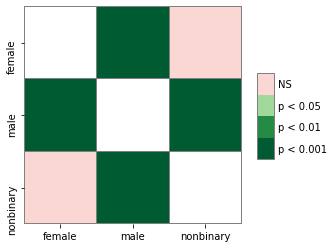

In [ ]:
pc = sp.posthoc_conover(df, val_col='tbpolarity', group_col='Gender')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args)

In [ ]:
pt = pg.pairwise_tukey(dv='tbpolarity', between='Gender', data=df)
pt

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,female,male,0.202174,0.180773,0.021401,0.004599,4.653177,0.001000,0.065803
1,female,nonbinary,0.202174,0.196468,0.005706,0.004599,1.240633,0.431072,0.017545
2,male,nonbinary,0.180773,0.196468,-0.015695,0.004599,-3.412544,0.001864,-0.048259


nltkpolarity between genders

In [ ]:
sp.posthoc_conover(df, val_col='nltkpolarity', group_col='Gender', p_adjust = 'holm')

,female,male,nonbinary
female,1.000000,1.232430e-05,8.417166e-03
male,0.000012,1.000000e+00,2.538152e-12
nonbinary,0.008417,2.538152e-12,1.000000e+00


(<matplotlib.axes._subplots.AxesSubplot at 0x7f53f0ce8bd0>,
 <matplotlib.colorbar.ColorbarBase at 0x7f53f0e333d0>)

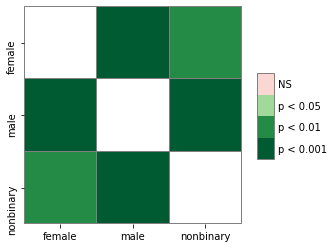

In [ ]:
pc = sp.posthoc_conover(df, val_col='nltkpolarity', group_col='Gender')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args)

In [ ]:
pt = pg.pairwise_tukey(dv='nltkpolarity', between='Gender', data=df)
pt

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,female,male,0.296698,0.263783,0.032915,0.0064,5.142981,0.001000,0.072730
1,female,nonbinary,0.296698,0.302095,-0.005397,0.0064,-0.843363,0.661073,-0.011927
2,male,nonbinary,0.263783,0.302095,-0.038312,0.0064,-5.986344,0.001000,-0.084657


compoundsent between genders

In [ ]:
sp.posthoc_conover(df, val_col='compoundsent', group_col='Gender', p_adjust = 'holm')

,female,male,nonbinary
female,1.000000,3.536323e-06,5.163965e-01
male,0.000004,1.000000e+00,1.721660e-07
nonbinary,0.516397,1.721660e-07,1.000000e+00


(<matplotlib.axes._subplots.AxesSubplot at 0x7f53ebacc490>,
 <matplotlib.colorbar.ColorbarBase at 0x7f53f0a49350>)

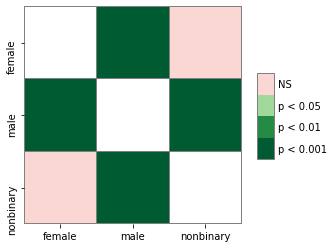

In [ ]:
pc = sp.posthoc_conover(df, val_col='compoundsent', group_col='Gender')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args)

In [ ]:
pt = pg.pairwise_tukey(dv='compoundsent', between='Gender', data=df)
pt

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,female,male,0.249436,0.222278,0.027158,0.00492,5.519476,0.001,0.078054
1,female,nonbinary,0.249436,0.249282,0.000154,0.00492,0.031358,0.900,0.000443
2,male,nonbinary,0.222278,0.249282,-0.027004,0.00492,-5.488119,0.001,-0.077611


clean_tbpolarity between genders

In [ ]:
sp.posthoc_conover(df, val_col='clean_tbpolarity', group_col='Gender', p_adjust = 'holm')

,female,male,nonbinary
female,1.000000,0.001917,0.549178
male,0.001917,1.000000,0.009734
nonbinary,0.549178,0.009734,1.000000


(<matplotlib.axes._subplots.AxesSubplot at 0x7f53f0f11650>,
 <matplotlib.colorbar.ColorbarBase at 0x7f53f0df4890>)

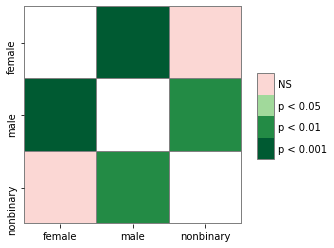

In [ ]:
pc = sp.posthoc_conover(df, val_col='clean_tbpolarity', group_col='Gender')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args)

In [ ]:
pt = pg.pairwise_tukey(dv='clean_tbpolarity', between='Gender', data=df)
pt

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,female,male,0.185872,0.168323,0.017550,0.004348,4.036032,0.001000,0.057076
1,female,nonbinary,0.185872,0.177027,0.008845,0.004348,2.034173,0.104169,0.028766
2,male,nonbinary,0.168323,0.177027,-0.008705,0.004348,-2.001858,0.111852,-0.028309


clean_nltk between genders

In [ ]:
sp.posthoc_conover(df, val_col='clean_nltkpolarity', group_col='Gender', p_adjust = 'holm')

,female,male,nonbinary
female,1.000000,9.752065e-05,1.385890e-04
male,0.000098,1.000000e+00,1.071429e-14
nonbinary,0.000139,1.071429e-14,1.000000e+00


(<matplotlib.axes._subplots.AxesSubplot at 0x7f53f0e10710>,
 <matplotlib.colorbar.ColorbarBase at 0x7f53eac0e3d0>)

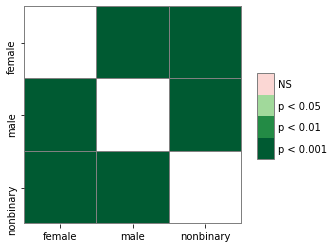

In [ ]:
pc = sp.posthoc_conover(df, val_col='clean_nltkpolarity', group_col='Gender')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args)

In [ ]:
pt = pg.pairwise_tukey(dv='clean_nltkpolarity', between='Gender', data=df)
pt

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,female,male,0.291762,0.262257,0.029505,0.006087,4.847282,0.001000,0.068548
1,female,nonbinary,0.291762,0.305482,-0.013720,0.006087,-2.254005,0.062531,-0.031875
2,male,nonbinary,0.262257,0.305482,-0.043225,0.006087,-7.101287,0.001000,-0.100424


cleancompoundsent between genders

In [ ]:
sp.posthoc_conover(df, val_col='clean_compoundsent', group_col='Gender', p_adjust = 'holm')

,female,male,nonbinary
female,1.000000,5.447299e-05,1.714434e-01
male,0.000054,1.000000e+00,7.991656e-08
nonbinary,0.171443,7.991656e-08,1.000000e+00


(<matplotlib.axes._subplots.AxesSubplot at 0x7f53f0f92410>,
 <matplotlib.colorbar.ColorbarBase at 0x7f53f0e6b890>)

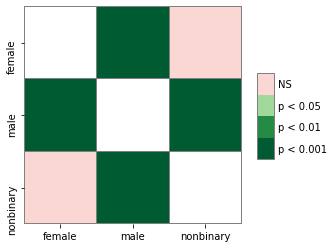

In [ ]:
pc = sp.posthoc_conover(df, val_col='clean_compoundsent', group_col='Gender')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args)

In [ ]:
pt = pg.pairwise_tukey(dv='clean_compoundsent', between='Gender', data=df)
pt

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,female,male,0.238817,0.215290,0.023527,0.004693,5.013374,0.001000,0.070897
1,female,nonbinary,0.238817,0.241254,-0.002437,0.004693,-0.519388,0.846404,-0.007345
2,male,nonbinary,0.215290,0.241254,-0.025965,0.004693,-5.532762,0.001000,-0.078242


## Toxicity Analysis

retrieving data (into a separate doc)

In [ ]:
from googleapiclient import discovery

API_KEY = "AUTHORS API KEY "


def init_client():
    return discovery.build(
        "commentanalyzer",
        "v1alpha1",
        developerKey=API_KEY,
        discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
    )


def perspective_scores(client, comment):
    attributes = [
        "TOXICITY",
        "SEVERE_TOXICITY",
    ]
    analyze_request = {
        "comment": {"text": comment},
        "requestedAttributes": {attr: {} for attr in attributes},
    }

    response = client.comments().analyze(body=analyze_request).execute()
    return {
        attr: response.get("attributeScores").get(attr).get("summaryScore").get("value")
        for attr in attributes
    }


In [ ]:
{
 "metadata": {
  "language_info": {
   "codemirror_mode": {
    "name": "ipython",
    "version": 3
   },
   "file_extension": ".py",
   "mimetype": "text/x-python",
   "name": "python",
   "nbconvert_exporter": "python",
   "pygments_lexer": "ipython3",
   "version": "3.9.0"
  },
  "orig_nbformat": 2,
  "kernelspec": {
   "name": "python390jvsc74a57bd0854a961f7b0779b08595c73b9c918da55d7d61f57ed73644562b328934fde2ca",
   "display_name": "Python 3.9.0 64-bit ('3.9.0': pyenv)"
  }
 },
 "nbformat": 4,
 "nbformat_minor": 2,
 "cells": [
  {
   "source": [
    "# Perspective API\n",
    "\n",
    "**Edit `perspective_api.py` and add your API key to line 4**"
   ],
   "cell_type": "markdown",
   "metadata": {}
  },
  {
   "cell_type": "code",
   "execution_count": 1,
   "metadata": {},
   "outputs": [],
   "source": [
    "import perspective_api as pers"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 2,
   "metadata": {},
   "outputs": [],
   "source": [
    "client = pers.init_client()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 4,
   "metadata": {},
   "outputs": [
    {
     "output_type": "execute_result",
     "data": {
      "text/plain": [
       "{'TOXICITY': 0.95979893,\n",
       " 'SEVERE_TOXICITY': 0.87427866,\n",
       " 'IDENTITY_ATTACK': 0.58523935,\n",
       " 'INSULT': 0.88075686,\n",
       " 'THREAT': 0.46016228,\n",
       " 'SEXUALLY_EXPLICIT': 0.92567843,\n",
       " 'FLIRTATION': 0.86841965,\n",
       " 'ATTACK_ON_AUTHOR': 0.6372158}"
      ]
     },
     "metadata": {},
     "execution_count": 4
    }
   ],
   "source": [
    "pers.perspective_scores(client, \"this video sucks and you suck, girl\")"
   ]
  }
 ]
}

analysis 

In [ ]:
dft = pd.read_csv("final_sampled_df_perspective_scores.csv", engine='python')

In [ ]:
dft["clean_text_nltk"] = dft.text.apply(str.lower)
dft["clean_text_nltk"] = dft.clean_text_nltk.apply(lambda x: " ".join(token for token in tokenizer.tokenize(x) if token not in stopwords))
dft["clean_text_nltk"] = dft.clean_text_nltk.str.translate(str.maketrans(dict.fromkeys(string.punctuation, "")))

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
dft.keys()

In [ ]:
 dft = dft.drop(dft[dft.TOXICITY == "invalid_lang"].index)

In [ ]:
dft = dft.replace('invalid_lang', np.NaN)

In [ ]:
dft.TOXICITY= dft.TOXICITY.astype(str).astype(float)
dft.SEVERE_TOXICITY= dft.SEVERE_TOXICITY.astype(str).astype(float)
dft.IDENTITY_ATTACK= dft.IDENTITY_ATTACK.astype(str).astype(float)
dft.INSULT= dft.INSULT.astype(str).astype(float)
dft.THREAT= dft.THREAT.astype(str).astype(float)
dft.SEXUALLY_EXPLICIT= dft.SEXUALLY_EXPLICIT.astype(str).astype(float)
dft.FLIRTATION= dft.FLIRTATION.astype(str).astype(float)
dft.ATTACK_ON_AUTHOR= dft.ATTACK_ON_AUTHOR.astype(str).astype(float)

In [ ]:
dft.groupby("Gender").TOXICITY.describe()

In [ ]:
dft[(dft["TOXICITY"] >= 0.8) & (dft["Gender"] == "nonbinary")].text.sample(10) #change genders for different overviews

In [ ]:
dft['logTOXICITY'] = np.log2(dft['TOXICITY'])

In [ ]:

dft.boxplot('TOXICITY', by='Gender', figsize=(8, 6))


In [ ]:
dft.boxplot('logTOXICITY', by='Gender', figsize=(8, 6))

In [ ]:
model = ols('logTOXICITY ~ Gender', data=dft).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table


In [ ]:
res = model.resid
fig = sm.qqplot(res, line='s')
plt.show()

In [ ]:
aov = pg.anova(data=dft, dv='logTOXICITY', between='Gender', detailed=True)
aov

In [ ]:
pt = pg.pairwise_tukey(dv='TOXICITY', between='Gender', data=dft)
pt

In [ ]:
dft.groupby("Gender").SEVERE_TOXICITY.describe()

In [ ]:
dft['logSEVERE_TOXICITY'] = np.log10(dft['SEVERE_TOXICITY'])

In [ ]:
dft.boxplot('logSEVERE_TOXICITY', by='Gender', figsize=(8, 6))

In [ ]:
model1 = ols('logSEVERE_TOXICITY ~ Gender', data=dft).fit()
anova_table1 = sm.stats.anova_lm(model, typ=2)
anova_table1

In [ ]:
res1 = model1.resid
fig1 = sm.qqplot(res, line='s')
plt.show()

In [ ]:
male = dft[dft["Gender"] == "male"]["SEVERE_TOXICITY"]
female = dft[dft["Gender"] == "female"]["SEVERE_TOXICITY"]
nonbinary = dft[dft["Gender"] == "nonbinary"]["SEVERE_TOXICITY"]

In [ ]:
stat, p = kruskal(male, female, nonbinary)
print('Statistics=%.3f, p=%.3f' % (stat, p))

In [ ]:
sp.posthoc_conover(dft, val_col='SEVERE_TOXICITY', group_col='Gender', p_adjust = 'holm')

In [ ]:
dft.groupby("Gender").IDENTITY_ATTACK.describe()

In [ ]:
dft[(dft["IDENTITY_ATTACK"] >= 0.9) & (dft["Gender"] == "nonbinary")].text

In [ ]:
dft['logIDENTITY_ATTACK'] = np.log2(dft['IDENTITY_ATTACK'])

In [ ]:
dft.boxplot('IDENTITY_ATTACK', by='Gender', figsize=(8, 6))

In [ ]:
model2 = ols('logIDENTITY_ATTACK ~ Gender', data=dft).fit()
anova_table2 = sm.stats.anova_lm(model, typ=2)
anova_table2

In [ ]:

res2 = model2.resid
fig2 = sm.qqplot(res, line='s')
plt.show()

In [ ]:
data = [dft.loc[ids, 'IDENTITY_ATTACK'].values for ids in dft.groupby('Gender').groups.values()]

In [ ]:

H, p = kruskal(*data)
H, p



In [ ]:
sp.posthoc_conover(dft, val_col='IDENTITY_ATTACK', group_col='Gender', p_adjust = 'holm')

In [ ]:
dft.groupby("Gender").INSULT.describe()

In [ ]:
dft[(dft["INSULT"] >= 0.9) & (dft["Gender"] == "nonbinary")].text.sample(20)

In [ ]:
dft['logINSULT'] = np.log10(dft['INSULT'])

In [ ]:
dft.boxplot('INSULT', by='Gender', figsize=(8, 6))

In [ ]:
model3 = ols('logINSULT ~ Gender', data=dft).fit()
anova_table3 = sm.stats.anova_lm(model3, typ=2)
anova_table3



In [ ]:
res3 = model3.resid
fig3 = sm.qqplot(res, line='s')
plt.show()

In [ ]:
pt = pg.pairwise_tukey(dv='INSULT', between='Gender', data=dft)
pt

In [ ]:
dft.groupby("Gender").THREAT.describe()

In [ ]:
#dft[(dft["THREAT"] >= 0.9) & (dft["Gender"] == "nonbinary")].text.sample(20)
dft[(dft["THREAT"] >= 0.9)].text.sample(20)

In [ ]:
count_ngrams(dft[(dft["THREAT"] >= 0.8) & (dft["Gender"] == "nonbinary")].clean_text_nltk,1).most_common(20)

In [ ]:
count_ngrams(dft[(dft["THREAT"] >= 0.8) & (dft["Gender"] == "nonbinary")].clean_text_nltk,2).most_common(20)

In [ ]:
count_ngrams(dft[(dft["THREAT"] >= 0.8)].clean_text_nltk,1).most_common(20)

In [ ]:
count_ngrams(dft[(dft["THREAT"] >= 0.8)].clean_text_nltk,2).most_common(20)

In [ ]:
dft[(dft.clean_text_nltk.str.contains("dead")) & (dft["THREAT"] >= 0.8)].clean_text_nltk.sample(15)

In [ ]:
dft.groupby("Gender").SEXUALLY_EXPLICIT.describe()

In [ ]:
print(dft.loc[dft["SEXUALLY_EXPLICIT"] >= 0.8].text.sample(10))

In [ ]:
dft.boxplot('SEXUALLY_EXPLICIT', by='Gender', figsize=(8, 6))

In [ ]:
model4 = ols('SEXUALLY_EXPLICIT ~ Gender', data=dft).fit()
anova_table4 = sm.stats.anova_lm(model4, typ=2)
anova_table4

In [ ]:
res4 = model4.resid
fig4 = sm.qqplot(res, line='s')
plt.show()

In [ ]:
pt = pg.pairwise_tukey(dv='SEXUALLY_EXPLICIT', between='Gender', data=dft)
pt

In [ ]:
dft.groupby("Gender").FLIRTATION.describe()

In [ ]:
dft[dft["FLIRTATION"] >= 0.9].text.sample(10)

In [ ]:
dft[(dft["FLIRTATION"] >= 0.8) & (dft["Gender"] == "male")].text.sample(10)

In [ ]:
dft.boxplot('FLIRTATION', by='Gender', figsize=(8, 6))

In [ ]:
model5 = ols('FLIRTATION ~ Gender', data=dft).fit()
anova_table5 = sm.stats.anova_lm(model5, typ=2)
anova_table5

In [ ]:
res5 = model5.resid
fig5 = sm.qqplot(res, line='s')
plt.show()

In [ ]:
pt = pg.pairwise_tukey(dv='FLIRTATION', between='Gender', data=dft)
pt

In [ ]:
dft.groupby("Gender").ATTACK_ON_AUTHOR.describe()

In [ ]:
dft[(dft["ATTACK_ON_AUTHOR"] >= 0.9) & (dft["Gender"] == "nonbinary")].text.sample(10)

In [ ]:
wordcounter_fem = count_words(dft[(dft["ATTACK_ON_AUTHOR"] >= 0.8) & (dft["Gender"] == "male")] ['clean_text_nltk']) 
wordcounter_fem.most_common(10)

In [ ]:
wordcounter_fem = count_words(dft[(dft["ATTACK_ON_AUTHOR"] >= 0.8)] ['clean_text_nltk']) 
wordcounter_fem.most_common(10)

In [ ]:
def count_ngrams(text_column, n):
    fdist = nltk.FreqDist()
    for text in text_column:
        fdist.update(nltk.ngrams(text.split(), n))
    return fdist


In [ ]:
count_ngrams(dft[(dft["ATTACK_ON_AUTHOR"] >= 0.8) & (dft["Gender"] == "nonbinary")].clean_text_nltk,1).most_common(20)



In [ ]:
count_ngrams(dft[(dft["ATTACK_ON_AUTHOR"] >= 0.8)].clean_text_nltk,2).most_common(20)


In [ ]:
count_ngrams(dft.text, 2).most_common(50)


In [ ]:
dft[(dft.clean_text_nltk.str.contains("james")) & (dft["ATTACK_ON_AUTHOR"] >= 0.8)].text #replace with bob

## Language Analysis

In [ ]:
texl70 = df['clean_text']
langdet = []                                                    
for i in range(len(df)):                                         
    try:                                                          
       lang=detect(texl70[i])                                      
    except:                                                       
       lang='no'                                                  
       #print("This row throws error:", texl70[i])                 
    langdet.append(lang)  

In [ ]:
df["langdet"] = langdet

In [ ]:
df[["langdet", "clean_text"]].sample(10)

In [ ]:
counted_lang = count_emojis(df['langdet'])
counted_lang.most_common()

In [ ]:
langcounter = count_emojis(df[df['Gender']=="nonbinary"]['langdet']) 
langcounter.most_common(50)

In [ ]:
df[df['langdet']=="en"]['text'].sample(10)

# Machine Learning -Abusive Language Detection


loading training dataset

In [ ]:
df1 = pd.read_csv("ALYT_data.csv")

normalization - filtering for only abusive and non-abusive comments (no neutral scores 0)

In [ ]:
df_alyt = df1[df1.label_normalised != 0]

class distribution checking

In [ ]:
df_alyt.label_normalised.value_counts().plot.bar()

In [ ]:
df_alyt.label_normalised.value_counts(normalize=True)*100

## preprocessing

In [ ]:

nltk.download('stopwords')

tokenizer = TweetTokenizer()
stopwords = nltk.corpus.stopwords.words('english')

In [ ]:
df_alyt["clean_text_nltk"] = df_alyt.comment.apply(str.lower)
df_alyt["clean_text_nltk"] = df_alyt.clean_text_nltk.apply(lambda x: " ".join(token for token in tokenizer.tokenize(x) if token not in stopwords))
df_alyt["clean_text_nltk"] = df_alyt.clean_text_nltk.str.translate(str.maketrans(dict.fromkeys(string.punctuation, "")))

## feature extraction

Bag of words

In [ ]:
vectorizer = CountVectorizer()
bow = vectorizer.fit(df_alyt.clean_text_nltk)
bow_features = vectorizer.transform(df_alyt.clean_text_nltk)

Tfidf

In [ ]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit(df_alyt.clean_text_nltk)
tfidf_features = vectorizer.transform(df_alyt.clean_text_nltk)

Embeddings

In [ ]:
model = SentenceTransformer('paraphrase-distilroberta-base-v1')

In [ ]:
embeddings = df_alyt['clean_text_nltk'].apply(lambda x: model.encode(x))

In [ ]:
X_emb = embeddings
Y = df_alyt.label_normalised
print(X_emb, Y.shape)

In [ ]:
X_embb = np.vstack(X_emb.values)
X_embb.shape

## Preparing the data

In [ ]:
X_bow = bow_features
X_tfidf = tfidf_features
Y = df_alyt.label_normalised

In [ ]:
train_X_bow, test_X_bow, train_y, test_y = train_test_split(X_bow, Y, test_size=0.2, random_state=18)
train_X_tfidf, test_X_tfidf, test_y,train_y= train_test_split(X_tfidf, Y, test_size=0.2, random_state=18)
train_X_emb, test_X_emb, train_y, test_y = train_test_split(X_embb, Y, test_size=0.2, random_state=18)

undersampling

In [ ]:
#define undersample strategy - bow
undersample = RandomUnderSampler(sampling_strategy = 0.5)
x_resampled_Bow, y_resampled = undersample.fit_resample(X_bow, Y)
print(sorted(Counter(y_resampled).items()), y_resampled.shape)

# define undersample strategy - tfidf
undersample = RandomUnderSampler(sampling_strategy = 0.5)
x_resampled_tdidf, y_resampled = undersample.fit_resample(X_tfidf, Y)
print(sorted(Counter(y_resampled).items()), y_resampled.shape)

#embeddings
undersample = RandomUnderSampler(sampling_strategy = 0.5) 
X_resampled_emb, y_resampled_emb = undersample.fit_resample(X_embb, Ye)

In [ ]:
train_X_emb, test_X_emb, _, _ = train_test_split(X_embb, Y, test_size=0.2, random_state=18)

In [ ]:
train_X_resampled_emb, test_X_resampled_emb, train_y_US, test_y_US = train_test_split(X_resampled_emb, y_resampled_emb, test_size=0.2, random_state=18)


In [ ]:
train_x_resampled_Bow, test_x_resampled_Bow, train_y_US, test_y_US = train_test_split(x_resampled_Bow, y_resampled, test_size=0.2, random_state=18)
train_x_resampled_tdidf, test_x_resampled_tdidf, _, _= train_test_split(x_resampled_tdidf, y_resampled, test_size=0.2, random_state=18)

## Training clasifiers

### SVM

In [ ]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear', class_weight={-1: 0.4, 1: 0.91}) # Linear Kernel

#Train the model using the training sets (bow)
clf.fit(train_X_bow, train_y)

#Predict the response for test dataset (bow)
y_pred_bowSVM = clf.predict(test_X_bow)

##Train the model using the training sets (tf-idf)
clf.fit(train_X_tfidf, train_y)

#Predict the response for test dataset (tf-idf)
y_pred_tfidfSVM = clf.predict(test_X_tfidf)

In [ ]:
#embeddings basic
clf.fit(train_X_emb, train_y)
y_pred_embSVM = clf.predict(test_X_emb)

undersampled svm

In [ ]:
#Create a svm Classifier - undersampled data
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets (bow)
clf.fit(train_x_resampled_Bow, train_y_US)

#Predict the response for test dataset (bow)
y_pred_bowSVM_US = clf.predict(test_x_resampled_Bow)

##Train the model using the training sets (tf-idf)
clf.fit(train_x_resampled_tdidf, train_y_US)

#Predict the response for test dataset (tf-idf)
y_pred_tfidfSVM_US = clf.predict(test_x_resampled_tdidf)

undersampled + weighted class

In [ ]:
#Create a svm Classifier - undersampled data WITH class_weight
clf1 = svm.SVC(kernel='linear', class_weight={-1: 0.4, 1: 0.91}) # Linear Kernel

#Train the model using the training sets (bow)
clf1.fit(train_x_resampled_Bow, train_y_US)

#Predict the response for test dataset (bow)
y_pred_bowSVM_US_CW = clf1.predict(test_x_resampled_Bow)

##Train the model using the training sets (tf-idf)
clf1.fit(train_x_resampled_tdidf, train_y_US)

#Predict the response for test dataset (tf-idf)
y_pred_tfidfSVM_US_CW = clf1.predict(test_x_resampled_tdidf)

In [ ]:
#embeddings both
clf1.fit(train_X_resampled_emb, train_y_US)
y_pred_embSVM_w_US = clf1.predict(test_X_resampled_emb)

### Logistic Reg

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier_bowLR = LogisticRegression(random_state=18, n_jobs=4) classifier_tfidfLR = LogisticRegression(random_state=18, n_jobs=4)

Bag-of-words
classifier_bowLR.fit(train_X_bow, train_y) pred_y_bow = classifier_bowLR.predict(test_X_bow)

Tf-idf
classifier_tfidfLR.fit(train_X_tfidf, train_y) pred_y_tfidf = classifier_tfidfLR.predict(test_X_tfidf)

weighted

In [ ]:
#LogisticRegression - balanced

classifier_bowLRB = LogisticRegression(random_state=18, n_jobs=4, class_weight={-1: 0.4, 1: 0.91})
classifier_tfidfLRB = LogisticRegression(random_state=18, n_jobs=4, class_weight={-1: 0.4, 1: 0.91})

# Bag-of-words
classifier_bowLRB.fit(train_X_bow, train_y)
pred_y_bowB = classifier_bowLRB.predict(test_X_bow)

# Tf-idf
classifier_tfidfLRB.fit(train_x_resampled_tdidf, train_y_US)
pred_y_tfidfB = classifier_tfidfLRB.predict(test_X_tfidf)

In [ ]:
#embeddings
classifier_bowLRB.fit(train_X_emb, train_y)
y_pred_embLR = classifier_bowLRB.predict(test_X_emb)

undersampled

In [ ]:
##Create LogisticRegression - undersampled data
classifier_bow_US = LogisticRegression(random_state=18, n_jobs=4)
classifier_tfidf_US = LogisticRegression(random_state=18, n_jobs=4)

#Bag-of-words
classifier_bow_US.fit(train_x_resampled_Bow, train_y_US)
pred_y_bow_US = classifier_bow_US.predict(test_x_resampled_Bow)

# Tf-idf
classifier_tfidf_US.fit(train_x_resampled_tdidf, train_y_US)
pred_y_tfidf_US = classifier_tfidf_US.predict(test_x_resampled_tdidf)

undersampled + weighted

In [ ]:
#LogisticRegression - undersampled - balanced
classifier_bow_UScw = LogisticRegression(random_state=18, n_jobs=4, class_weight={-1: 0.4, 1: 0.91})
classifier_tfidf_UScw = LogisticRegression(random_state=18, n_jobs=4, class_weight={-1: 0.4, 1: 0.91})

#Bag-of-words
classifier_bow_UScw.fit(train_x_resampled_Bow, train_y_US)
pred_y_bow_UScw = classifier_bow_UScw.predict(test_x_resampled_Bow)

# Tf-idf
classifier_tfidf_UScw.fit(train_x_resampled_tdidf, train_y_US)
pred_y_tfidf_UScw = classifier_tfidf_UScw.predict(test_x_resampled_tdidf)

In [ ]:
classifier_bow_UScw.fit(train_X_resampled_emb, train_y_US)
y_pred_embLR_w_US = classifier_bow_UScw.predict(test_X_resampled_emb)

### Random Forest

In [ ]:
clf_bow_rf = RandomForestClassifier(n_estimators=100, random_state=18)
clf_tfidf_rf = RandomForestClassifier(n_estimators=100, random_state=18)

In [ ]:
#Bag of words
clf_bow_rf.fit(train_X_bow, train_y)
pred_y_bow_rf = clf_bow_rf.predict(test_X_bow)

# Tf-idf
clf_tfidf_rf.fit(train_X_tfidf, train_y)
pred_y_tfidf_rf = clf_tfidf_rf.predict(test_X_tfidf)

In [ ]:
clf_tfidf_rf.predict_proba(test_X_tfidf)

weighted

In [ ]:
#Create an RF Classifier
clf_bow_rfw = RandomForestClassifier(n_estimators=100, random_state=18, class_weight={-1: 0.4, 1: 0.91})
clf_tfidf_rfw = RandomForestClassifier(n_estimators=100, random_state=18, class_weight={-1: 0.4, 1: 0.91})

#Train the model using the training sets (bow)
clf_bow_rfw.fit(train_X_bow, train_y)

#Predict the response for test dataset (bow)
pred_y_bow_rfw = clf_bow_rfw.predict(test_X_bow)

##Train the model using the training sets (tf-idf)
clf_tfidf_rfw.fit(train_X_tfidf, train_y)

#Predict the response for test dataset (tf-idf)
pred_y_tfidf_rfw = clf_tfidf_rfw.predict(test_X_tfidf)

undersampled

In [ ]:
clf_rf_bow_US = RandomForestClassifier(n_estimators=100, random_state=18)
clf_rf_tfidf_US = RandomForestClassifier(n_estimators=100, random_state=18)

#Bag-of-words
clf_rf_bow_US.fit(train_x_resampled_Bow, train_y_US)
pred_y_bow_rfw_US = clf_rf_bow_US.predict(test_x_resampled_Bow)

# Tf-idf
clf_rf_tfidf_US.fit(train_x_resampled_tdidf, train_y_US)
pred_y_tfidf_rfw_US = clf_rf_tfidf_US.predict(test_x_resampled_tdidf)

weighetd + undersampled

In [ ]:
clf_rf_bow_UScw = RandomForestClassifier(n_estimators=100, random_state=18, class_weight={-1: 0.4, 1: 0.91})
clf_tfidf_tfidf_UScw = RandomForestClassifier(n_estimators=100, random_state=18, class_weight={-1: 0.4, 1: 0.91})

#Bag-of-words
clf_rf_bow_UScw.fit(train_x_resampled_Bow, train_y_US)
pred_y_bow_rfw_UScw = clf_rf_bow_UScw.predict(test_x_resampled_Bow)

# Tf-idf
clf_tfidf_tfidf_UScw.fit(train_x_resampled_tdidf, train_y_US)
pred_y_tfidf_rfw_UScw = clf_tfidf_tfidf_UScw.predict(test_x_resampled_tdidf)

## evaluation

log reg

In [ ]:
from sklearn.metrics import classification_report
#LogisticRegression model - unbalanced
print(classification_report(test_y, pred_y_bow))
print(classification_report(test_y, pred_y_tfidf))

In [ ]:
#LogisticRegression model - weighted
print(classification_report(test_y, pred_y_bowB))
print(classification_report(test_y, pred_y_tfidfB))
print(classification_report(test_y, y_pred_embLR))

In [ ]:
#LogisticRegression model- undersampled
print(classification_report(test_y_US, pred_y_bow_US))
print(classification_report(test_y_US, pred_y_tfidf_US))

In [ ]:
#LogisticRegression model- undersampled - balanced
print(classification_report(test_y_US, pred_y_bow_UScw))
print(classification_report(test_y_US, pred_y_tfidf_UScw))
print(classification_report(test_y_US, y_pred_embLR_w_US))

svm

In [ ]:
#SVM 
print(classification_report(test_y, y_pred_bowSVM))
print(classification_report(test_y, y_pred_tfidfSVM ))
print(classification_report(test_y, y_pred_embSVM_w))

In [ ]:
#SVM model - using undersampled data (NON-balanced)
print(classification_report(test_y_US, y_pred_bowSVM_US))
print(classification_report(test_y_US, y_pred_tfidfSVM_US ))

In [ ]:
#SVM model - using undersampled data (balanced- weighted)
print(classification_report(test_y_US, y_pred_bowSVM_US_CW))
print(classification_report(test_y_US, y_pred_tfidfSVM_US_CW))
print(classification_report(test_y_US, y_pred_embSVM_w_US))

random forest

In [ ]:
print(classification_report(test_y, pred_y_bow_rf))
print(classification_report(test_y, pred_y_tfidf_rf))

In [ ]:
print(classification_report(test_y_US, pred_y_bow_rfw))
print(classification_report(test_y_US, pred_y_tfidf_rfw))

In [ ]:
print(classification_report(test_y_US, pred_y_bow_rfw_US))
print(classification_report(test_y_US, pred_y_tfidf_rfw_US))

In [ ]:
print(classification_report(test_y_US, pred_y_bow_rfw_UScw))
print(classification_report(test_y_US, pred_y_tfidf_rfw_UScw))
print(classification_report(test_y_US,y_pred_embRF_w_US)) 

## Application of the trained model

In [ ]:
def abusive_language_probability(comment, vectorizer, classifier):
    # We are assuming that the comment is already preprocessed and tokenized
    comment_vec = vectorizer.transform([comment])
    return classifier.predict_proba(comment_vec)

In [ ]:
def abusive_language_score(comment, vectorizer, classifier):
    # We are assuming that the comment is already preprocessed and tokenized
    comment_vec = vectorizer.transform([comment])
    nonabusive_score, abusive_score = classifier.predict_proba(comment_vec)[0]
    return -abusive_score if abusive_score >= nonabusive_score else nonabusive_score

In [ ]:
dfo = pd.read_csv("final_tokenized_sample_comments.csv", engine='python')


In [ ]:
dfo["text1"] = dfo.clean_text.astype(str)

In [ ]:
dfo["clean_text_nltk"] = dfo.text1.apply(str.lower)
dfo["clean_text_nltk"] = dfo.clean_text_nltk.apply(lambda x: " ".join(token for token in tokenizer.tokenize(x) if token not in stopwords))
dfo["clean_text_nltk"] = dfo.clean_text_nltk.str.translate(str.maketrans(dict.fromkeys(string.punctuation, "")))

In [ ]:
#Tfidf
vectorizer = TfidfVectorizer()
tfidf1 = vectorizer.fit(dfo.clean_text_nltk)
tfidf1_features = vectorizer.transform(dfo.clean_text_nltk)

In [ ]:
#LogisticRegression - undersampled - balanced

clf_final = LogisticRegression(random_state=18, n_jobs=4, class_weight={-1: 0.4, 1: 0.91})
clf_final_us = LogisticRegression(random_state=18, n_jobs=4)


# Tf-idf
clf_final.fit(x_resampled_tdidf, y_resampled)
#pred_y_tfidf_final= clf_final.predict(tfidf1)


clf_final_us.fit(x_resampled_tdidf, y_resampled)

In [ ]:
dfo["prediction2"] = dfo.clean_text_nltk.apply(lambda x: abusive_language_score(x, tfidf, clf_final_us)) 

In [ ]:
dfo["prediction1"] = dfo.clean_text_nltk.apply(lambda x: abusive_language_score(x, tfidf, clf_final))

In [ ]:
eli5.show_weights(clf_final_us, feature_names=tfidf.get_feature_names(), target_names=["non-abusive", "abusive"], top=(10, 10))

In [ ]:
comment = dfo[dfo.prediction2 <= -0.8].text.sample(1).values
print(comment)

eli5.show_prediction(clf_final_us, doc=tfidf.transform(comment), feature_names=tfidf.get_feature_names())

In [ ]:
count_ngrams(dfo[(dfo["prediction2"] >= 0.8) & (dft["Gender"] == "nonbinary")].clean_text_nltk,1).most_common(20)

In [ ]:
count_ngrams(dfo[(dfo["prediction2"] <= -0.8)].clean_text_nltk,2).most_common(20)

In [ ]:
dfo[(dfo.text.str.contains("bitch")) & (dfo["prediction2"] <= -0.8)].text

In [ ]:
count_ngrams(dfo[(dfo["prediction2"] >= 0.8)].clean_text_nltk,2).most_common(20)

In [ ]:

dfo[(dfo["prediction2"] <= -0.8) & (dfo["Gender"] == "female")].text

dfo[["prediction1","prediction2"]].describe() 

In [ ]:
dfo.prediction1.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')

In [ ]:
dfo.prediction2.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')

In [ ]:
comb_df=dfo

In [ ]:
stats.wilcoxon(comb_df['prediction1'], comb_df['prediction2']) #significantly different 

## ANOVA

In [ ]:
comb_df.groupby("Gender").prediction2.describe()

In [ ]:
comb_df.boxplot('prediction2', by='Gender', figsize=(8, 6))

In [ ]:
model_e = ols('prediction2 ~ Gender', data=comb_df).fit()
anova_table_e = sm.stats.anova_lm(model_e, typ=2)
anova_table_e

res = model_e.resid
fig = sm.qqplot(res, line='s')
plt.show()


In [ ]:
aov = pg.anova(data=comb_df, dv='prediction2', between='Gender', detailed=True)
aov

In [ ]:
pt = pg.pairwise_tukey(dv='prediction2', between='Gender', data=comb_df)
pt